In [2]:
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import math
import time
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from tqdm import tqdm

# Классификатор
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
import pandas as pd
import logging
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)
from sklearn.model_selection import train_test_split


def first(x, y):
    if x == True or x >= 75:
        return y + 2
    else:
        return y


def second(x, y):
    if x > 30 or x == True:
        return y + 1
    else:
        return y


def third(x, y):
    if x == True:
        return y + 4
    else:
        return y


def fourth(x, y):
    if x == '2':
        return y + 2
    else:
        return y


def havoc(data):
    data['havoc'] = 0
    data['havoc'] = data.apply(lambda x: first(x.hyp, x.havoc), axis=1)
    data['havoc'] = data.apply(lambda x: first(x.age, x.havoc), axis=1)
    data['havoc'] = data.apply(lambda x: first(x.VD, x.havoc), axis=1)
    data['havoc'] = data.apply(lambda x: fourth(x.cad, x.havoc), axis=1)
    data['havoc'] = data.apply(lambda x: second(x.PAD, x.havoc), axis=1)
    data['havoc'] = data.apply(lambda x: second(x.mass_index, x.havoc), axis=1)
    data['havoc'] = data.apply(lambda x: third(x.heart_failure, x.havoc), axis=1)

    return data

In [3]:

N_THREADS = 8 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 600 # Time in seconds for automl run
TARGET_NAME = 'y' # Target column name


np.random.seed(RANDOM_STATE)

# data = pd.read_csv("Results_with_drugs.csv", index_col=0)

In [9]:
data = pd.read_csv("Results_210121.csv", index_col=0)
print('Data uploaded')
data['creation_date'] = pd.to_datetime(data['creation_date'])
# diagnosis = 'PI48'
diafnosis = 'fibrillation'
data = data[data.doc_type == "DISCHARGE_GENERAL_CONCLUSION_1"]
data = (data[data['Status']=='Выписка из ИБ'])
# sum(data_2.values)
data = havoc(data)

Data uploaded


In [10]:
data.columns

Index(['Status', 'combined_id', 'id', 'doc_id', 'case_history_id', 'creation_date', 'update_date', 'doc_type', 'sex_given', 'patient_id', 'updated_link', 'sinus_rythm', 'Sin_date', 'PI48', 'sex', 'age', 'cad', 'hyp', 'mass_index', 'heart_failure', 'diabetes', 'tromb', 'VD', 'PAD', 'stroke', 'TIA', 'sys_thromb_emb', 'fibrillation', 'atherosclerosis', 'left_heart', 'ara2', 'ara2_dose', 'diuretic', 'diuretic_dose', 'war', 'war_dose', 'Istoria_Bolesni', 'CHA2DS2', 'havoc'], dtype='object')

In [11]:
# !индекс пациента -- !количество эпикриз для него
data_1 = data['patient_id'].value_counts()
# индексы людей, у которых больше одной эпикризы
data_2 = (data_1[data_1.values > 1])
list_of_inds_more_1 = list(data_2.index)


In [12]:
data_diag_true = data[data[diagnosis]==True]
len(data_diag_true)

4880

In [ ]:
len(data_without_1[data_without_1[diagnosis].isin([False, np.nan])])

In [14]:


data_without_1 = data 
data_without_1_with_diag = data_without_1[data_without_1[diagnosis]==True]
data_without_1_without_diag = data_without_1[data_without_1['fibrillation'].isin([False, np.nan])]

In [15]:


dw1wf = data_without_1_with_diag['patient_id'].value_counts().index
dw1withoutf = data_without_1_without_diag['patient_id'].value_counts().index
patients_without_fibrillation = list(set(dw1withoutf) - set(dw1wf))

array = dw1wf

array_false = patients_without_fibrillation


print('\nBefore list building\n')
array_of_patients = []

for i in tqdm(array):
    array_of_patients.append((data[data['patient_id']==i].sort_values(by=['creation_date'])))
print('\nFirst list is built\n')
array_false_of_patients = []

for i in tqdm(array_false):
    array_false_of_patients.append((data[data['patient_id']==i].sort_values(by=['creation_date'])))

print('\nSecond list is built\n')
new_array = []
for current_array in tqdm(array_of_patients):
    df_patient = current_array[current_array[diagnosis] == True].copy()
    df_patient['y'] = [1] * len(df_patient)
    new_array.append(df_patient)

print('\nFirst list is done\n')

new_false_array = []
for current_array in tqdm(array_false_of_patients):
    df_patient = current_array.copy()
    df_patient['y'] = 0
    new_false_array.append(df_patient)

print('\nSecond list is done\n')


new_new_array = new_array
new_new_false_array = new_false_array




  1%|▏         | 46/3487 [00:00<00:07, 456.82it/s]


Before list building



  0%|          | 102/42561 [00:00<00:41, 1015.62it/s]


First list is built



  3%|▎         | 96/3487 [00:00<00:03, 953.05it/s]


Second list is built



  1%|          | 229/42561 [00:00<00:18, 2282.43it/s]


First list is done



100%|██████████| 42561/42561 [00:19<00:00, 2221.81it/s]


Second list is done



In [16]:

concatinate_array_true = pd.concat(new_new_array)
concatinate_array_false = pd.concat(new_new_false_array)

In [17]:
print(len(concatinate_array_true))
print(len(concatinate_array_false))

4880
64459


In [18]:


# concatinate_array = concatinate_array_2year
# concatinate_array = pd.concat(concatinate_array, concatinate_array_false)
concatinate_array = concatinate_array_true.append(concatinate_array_false)
# concatinate_array = pd.concat(new_new_array + new_new_false_array)
# concatinate_array = concatinate_array[concatinate_array.differ<31536000]
concatinate_array = concatinate_array.drop(['id','doc_id','case_history_id', 'creation_date','update_date','doc_type','sex_given', 'patient_id', 'fibrillation', 'updated_link','Sin_date'], 1)
# concatinate_array = concatinate_array.drop(['aspirin', 'clopidogrel', 'ara2', 'ticagrelorum', 'ticagrelorum', 'diuretic', 'rivaroxabanum', 'apixabanum', 'war', 'dabigatrani', 'acenocoumarolum', 'prasugrelum'], 1)
# concatinate_array = concatinate_array.drop(['aspirin_dose', 'clopidogrel_dose', 'ara2_dose', 'ticagrelorum_dose', 'ticagrelorum_dose', 'diuretic_dose', 'rivaroxabanum_dose', 'apixabanum_dose', 'war_dose', 'dabigatrani_dose', 'acenocoumarolum_dose', 'prasugrelum_dose'], 1)
concatinate_array = concatinate_array.drop([ 'ara2',  'diuretic',   'war'], 1)
concatinate_array = concatinate_array.drop([ 'ara2_dose',  'diuretic_dose','war_dose'], 1)
# concatinate_array = concatinate_array.drop(['left_heart', 'PI48', 'Sin', 'tromb', 'atherosclerosis'], 1)
# concatinate_array = concatinate_array.drop(['PI48', 'Sin', 'tromb', 'atherosclerosis',  'height'], 1)
concatinate_array = concatinate_array.drop(['tromb', 'atherosclerosis', 'Status', 'combined_id', 'sys_thromb_emb', 'Istoria_Bolesni'], 1)
# concatinate_array = concatinate_array.drop(['havoc'], axis=1)
# concatinate_array = concatinate_array.drop(['weight', 'mass_index'], 1)
# concatinate_array = concatinate_array.drop(['PI48'], 1)





In [19]:
print('True values:', len(concatinate_array[concatinate_array.y==1]))
print('False values:', len(concatinate_array[concatinate_array.y==0]))

True values: 4880
False values: 64459


In [33]:
print(len(concatinate_array_true))

4880


In [23]:
print(concatinate_array.columns)

Index(['sinus_rythm', 'PI48', 'sex', 'age', 'cad', 'hyp', 'mass_index', 'heart_failure', 'diabetes', 'VD', 'PAD', 'stroke', 'TIA', 'left_heart', 'CHA2DS2', 'havoc', 'y'], dtype='object')


In [44]:
print(concatinate_array.isna().sum())

sinus_rythm      0
sex              0
age              0
cad              0
hyp              0
mass_index       0
heart_failure    0
diabetes         0
VD               0
PAD              0
stroke           0
TIA              0
left_heart       0
CHA2DS2          0
havoc            0
y                0
dtype: int64


In [24]:
label_encoder = LabelEncoder()

concatinate_array = concatinate_array.dropna()
concatinate_array.sex = label_encoder.fit_transform(concatinate_array.sex)
concatinate_array.y = label_encoder.fit_transform(concatinate_array.y)
concatinate_array.PAD = label_encoder.fit_transform(concatinate_array.PAD)
concatinate_array.cad = label_encoder.fit_transform(concatinate_array.cad)
concatinate_array.hyp = label_encoder.fit_transform(concatinate_array.hyp)
concatinate_array.heart_failure = label_encoder.fit_transform(concatinate_array.heart_failure)
concatinate_array.diabetes = label_encoder.fit_transform(concatinate_array.diabetes)
concatinate_array.VD = label_encoder.fit_transform(concatinate_array.VD)
concatinate_array.TIA = label_encoder.fit_transform(concatinate_array.TIA)

concatinate_array.sinus_rythm = label_encoder.fit_transform(concatinate_array.sinus_rythm)
concatinate_array.stroke = label_encoder.fit_transform(concatinate_array.stroke)

# concatinate_array.systTR = label_encoder.fit_transform(concatinate_array.systTR)
# concatinate_array.atherosclerosis = label_encoder.fit_transform(concatinate_array.atherosclerosis)
# concatinate_array.Sin = label_encoder.fit_transform(concatinate_array.Sin)
# concatinate_array.PI48 = label_encoder.fit_transform(concatinate_array.PI48)
# concatinate_array.tromb = label_encoder.fit_transform(concatinate_array.tromb)
try:
    concatinate_array.left_heart = concatinate_array.loc[:,'left_heart'].str.replace(',', '.').astype(float)
except:
    pass
# concatinate_array.left_heart = concatinate_array.left_heart.astype(float)
# data_for_classificator = concatinate_array.drop('differ',1)
# data_for_classificator = concatinate_array.copy()
print('data preprocessing is done')

data preprocessing is done


In [25]:
# concatinate_array.PI48 = label_encoder.fit_transform(concatinate_array.PI48)

In [26]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import statsmodels.api as sm
import patsy as pt
import sklearn.linear_model as lm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, precision_score, recall_score
from sklearn.utils import resample
# from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

# Trying different automl

In [38]:
concatinate_array = concatinate_array.drop('PI48', 1)

In [39]:
data_for_classificator = concatinate_array.drop(['havoc', 'CHA2DS2', 'sinus_rythm'], axis=1)

In [40]:
data_for_classificator

,sex,age,cad,hyp,mass_index,heart_failure,diabetes,VD,PAD,stroke,TIA,left_heart,y
2630,1,85.0,1,1,29.0,0,0,0,1,1,0,5.1,1
8737,1,86.0,1,1,29.0,0,0,0,1,1,0,5.1,1
125156,1,86.0,1,1,29.0,0,0,0,1,1,0,4.9,1
67901,1,87.0,1,1,29.0,0,0,0,1,1,0,5.1,1
109764,0,73.0,1,1,35.0,0,0,0,0,0,0,3.8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27875,1,63.0,1,1,27.0,0,0,0,0,0,0,3.5,0
76940,1,78.0,0,1,24.0,0,0,1,1,0,0,3.5,0
21605,0,55.0,0,1,22.0,0,0,0,1,1,0,3.6,0
76700,0,71.0,0,1,25.0,0,0,0,1,0,0,3.6,0


In [63]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

# Import a sample binary outcome train/test set into H2O
train_data, test_data = train_test_split(data_for_classificator,
                                         test_size=0.2,
                                         stratify=data_for_classificator[TARGET_NAME],
                                         random_state=RANDOM_STATE)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 3 mins
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_m_kuznetsov_o3j33t
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,13.80 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [64]:
print('True values:', len(data_for_classificator[data_for_classificator.y==1]))
print('False values:', len(data_for_classificator[data_for_classificator.y==0]))

True values: 2166
False values: 30897


In [65]:
data_all = train_data.copy()
data_true = data_all[data_all['y']==1]
data_false = data_all[data_all['y']==0]

data_all = shuffle(pd.concat([data_true, data_false]))

train_data = data_all.copy()

In [66]:
print('True values in train:', len(train_data[train_data.y==1]))
print('False values in train:', len(train_data[train_data.y==0]))

True values in train: 1733
False values in train: 24717


In [67]:
train_data = h2o.H2OFrame(train_data)
test_data = h2o.H2OFrame(test_data)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [68]:
len(train_data)

26450

In [69]:
len(test_data)

6613

In [70]:
# Identify predictors and response
x = train_data.columns
y = TARGET_NAME
x.remove(y)

# For binary classification, response should be a factor
train_data[y] = train_data[y].asfactor()
test_data[y] = test_data[y].asfactor()

In [71]:
%%time
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=x, y=y, training_frame=train_data)

AutoML progress: |████████████████████████████████████████████████████████| 100%
CPU times: user 35.7 s, sys: 172 ms, total: 35.8 s
Wall time: 4min 54s


In [72]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210421_175306,0.73709,0.218592,0.169081,0.370481,0.240827,0.0579976
StackedEnsemble_BestOfFamily_AutoML_20210421_175306,0.736301,0.219202,0.164233,0.367347,0.241156,0.0581564
GBM_1_AutoML_20210421_175306,0.73429,0.220284,0.162065,0.380295,0.241827,0.0584805
GBM_grid__1_AutoML_20210421_175306_model_1,0.732427,0.219954,0.16559,0.372199,0.241284,0.0582181
GBM_2_AutoML_20210421_175306,0.731932,0.220023,0.167546,0.374861,0.241347,0.0582483
XGBoost_grid__1_AutoML_20210421_175306_model_3,0.729651,0.220958,0.158231,0.361287,0.241891,0.0585113
XGBoost_3_AutoML_20210421_175306,0.72763,0.221306,0.159683,0.357229,0.241954,0.0585416
XGBoost_grid__1_AutoML_20210421_175306_model_1,0.726151,0.221567,0.159159,0.355748,0.242055,0.0585907
XGBoost_grid__1_AutoML_20210421_175306_model_4,0.7261,0.221509,0.160336,0.3873,0.241962,0.0585458
GBM_3_AutoML_20210421_175306,0.724276,0.222138,0.158636,0.378041,0.242275,0.0586974


In [56]:
len(lb)

22

In [73]:
preds = aml.leader.predict(test_data)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [74]:
preds

predict,p0,p1
0,0.984291,0.0157093
0,0.939745,0.0602554
0,0.94025,0.0597502
0,0.989373,0.0106271
0,0.962213,0.0377869
0,0.98931,0.0106901
0,0.977021,0.0229786
0,0.924583,0.0754165
0,0.997919,0.0020815
0,0.891951,0.108049


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_AutoML_20210421_175306,0.73709,0.218592,0.169081,0.370481,0.240827,0.0579976,841,0.02671,StackedEnsemble
StackedEnsemble_BestOfFamily_AutoML_20210421_175306,0.736301,0.219202,0.164233,0.367347,0.241156,0.0581564,645,0.020644,StackedEnsemble
GBM_1_AutoML_20210421_175306,0.73429,0.220284,0.162065,0.380295,0.241827,0.0584805,381,0.007302,GBM
GBM_grid__1_AutoML_20210421_175306_model_1,0.732427,0.219954,0.16559,0.372199,0.241284,0.0582181,354,0.008001,GBM
GBM_2_AutoML_20210421_175306,0.731932,0.220023,0.167546,0.374861,0.241347,0.0582483,411,0.007757,GBM
XGBoost_grid__1_AutoML_20210421_175306_model_3,0.729651,0.220958,0.158231,0.361287,0.241891,0.0585113,285,0.002607,XGBoost
XGBoost_3_AutoML_20210421_175306,0.72763,0.221306,0.159683,0.357229,0.241954,0.0585416,323,0.002639,XGBoost
XGBoost_grid__1_AutoML_20210421_175306_model_1,0.726151,0.221567,0.159159,0.355748,0.242055,0.0585907,496,0.002824,XGBoost
XGBoost_grid__1_AutoML_20210421_175306_model_4,0.7261,0.221509,0.160336,0.3873,0.241962,0.0585458,264,0.00271,XGBoost
GBM_3_AutoML_20210421_175306,0.724276,0.222138,0.158636,0.378041,0.242275,0.0586974,420,0.008224,GBM


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_AutoML_20210421_175306


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15239528842222444: 


,,0,1,Error,Rate
0,0,8889.0,466.0,0.0498,(466.0/9355.0)
1,1,386.0,278.0,0.5813,(386.0/664.0)
2,Total,9275.0,744.0,0.085,(852.0/10019.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

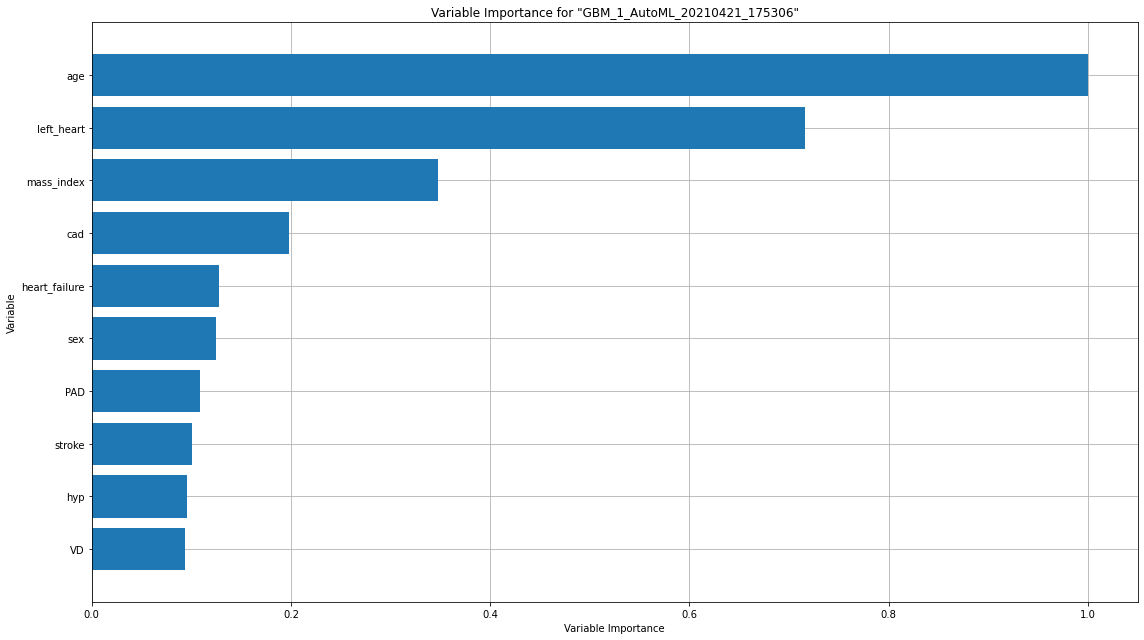

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

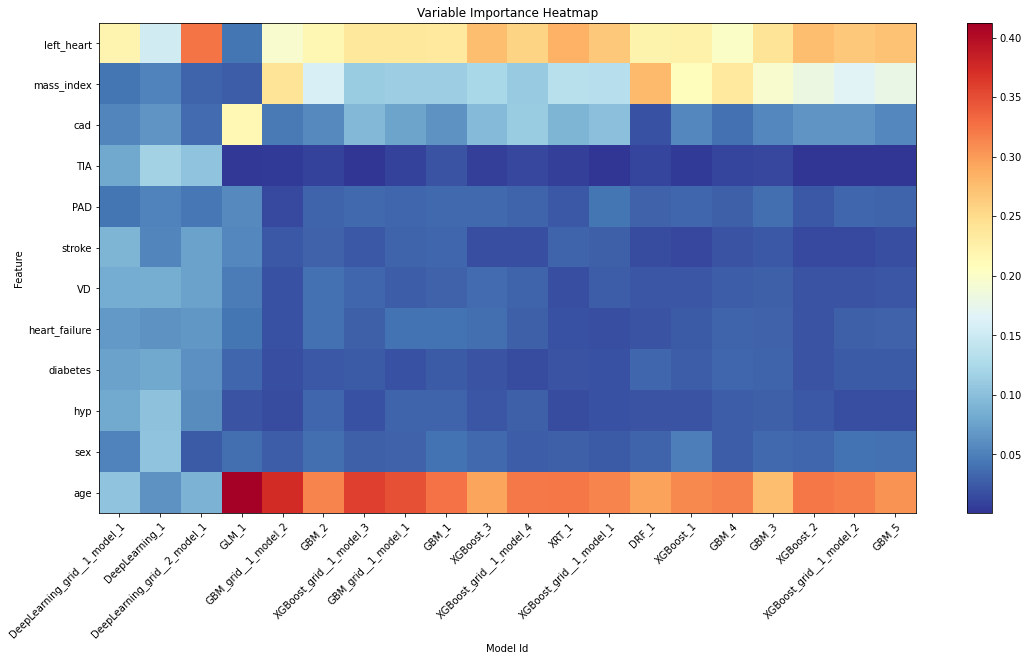

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

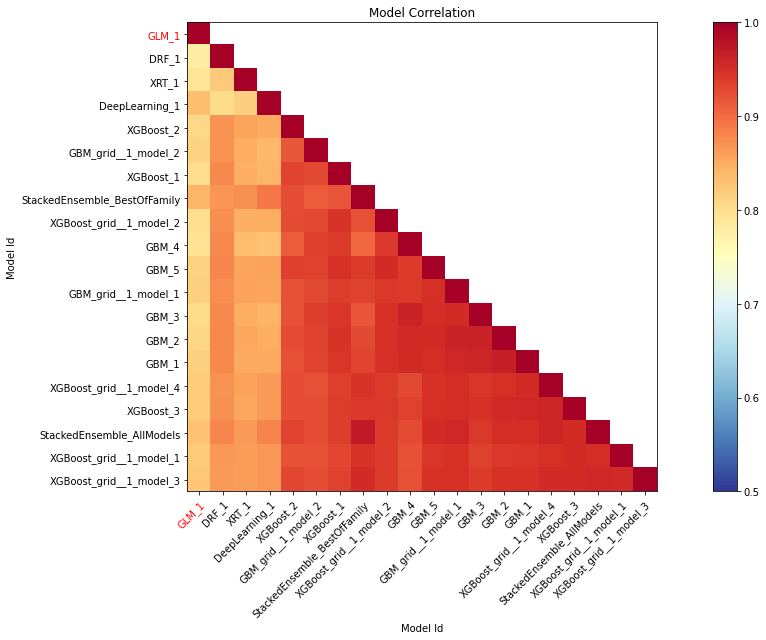

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

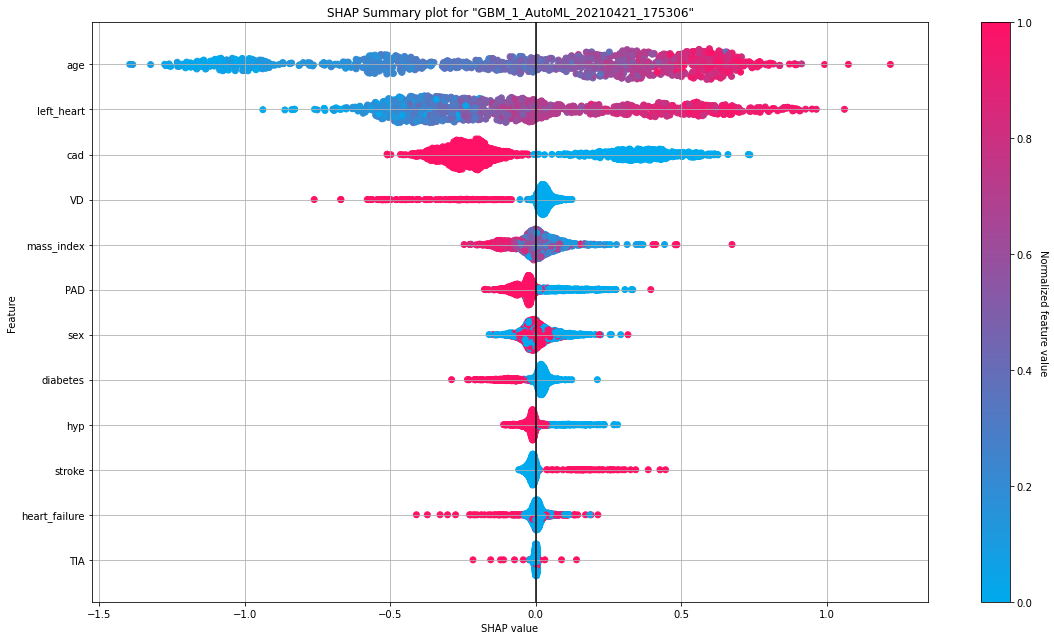

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

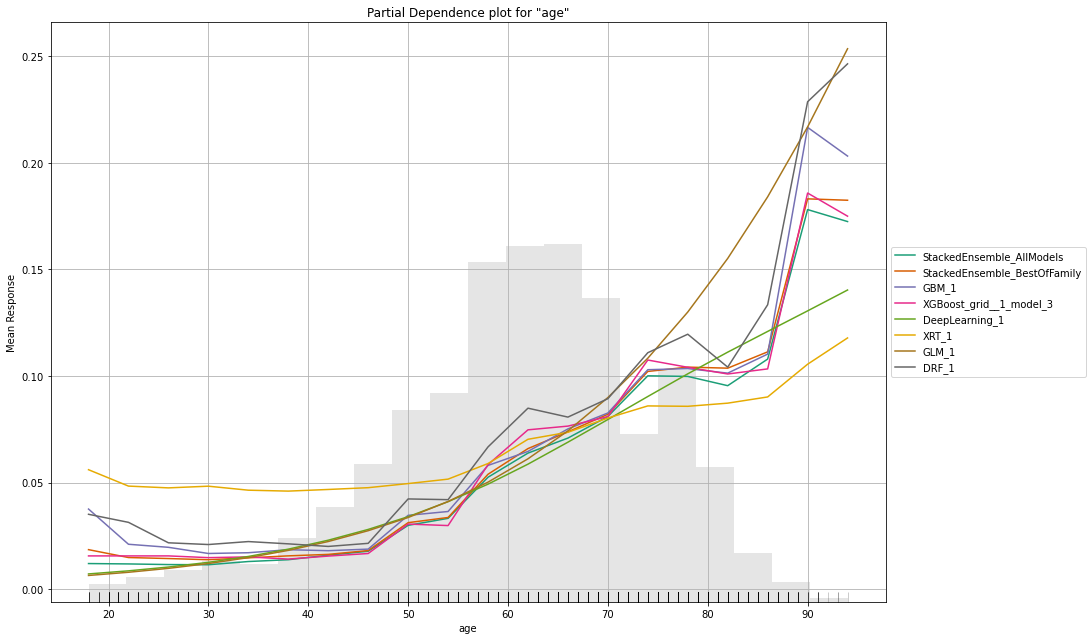

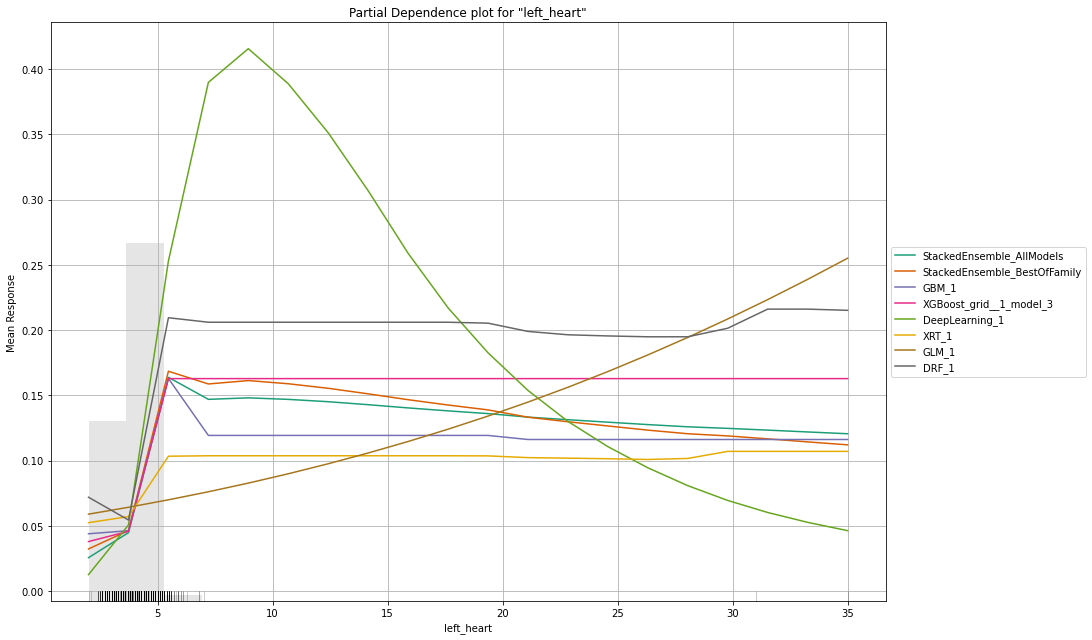

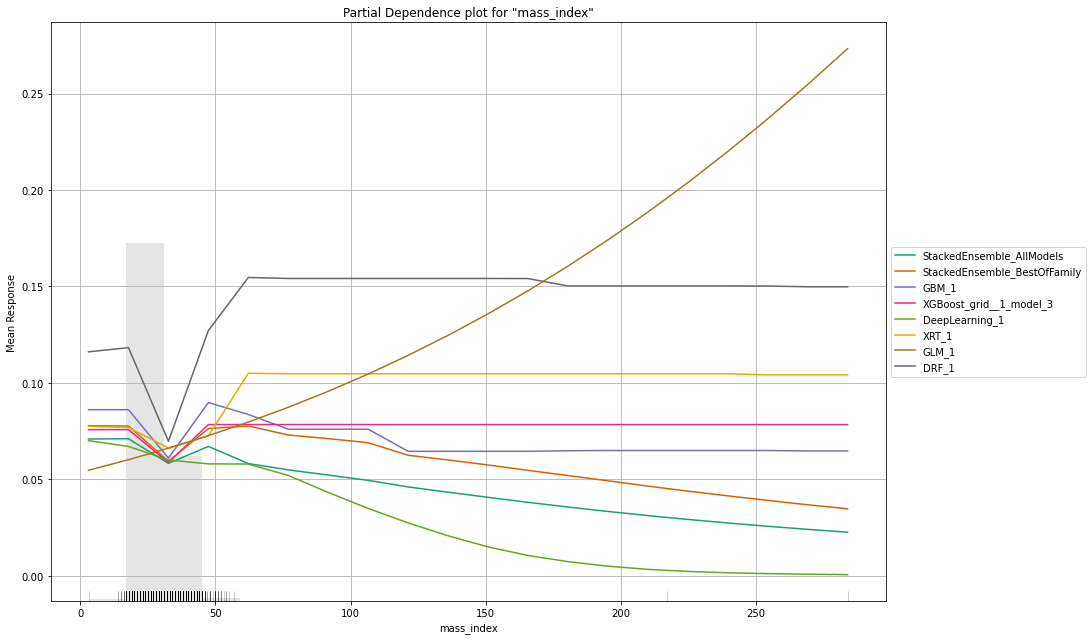

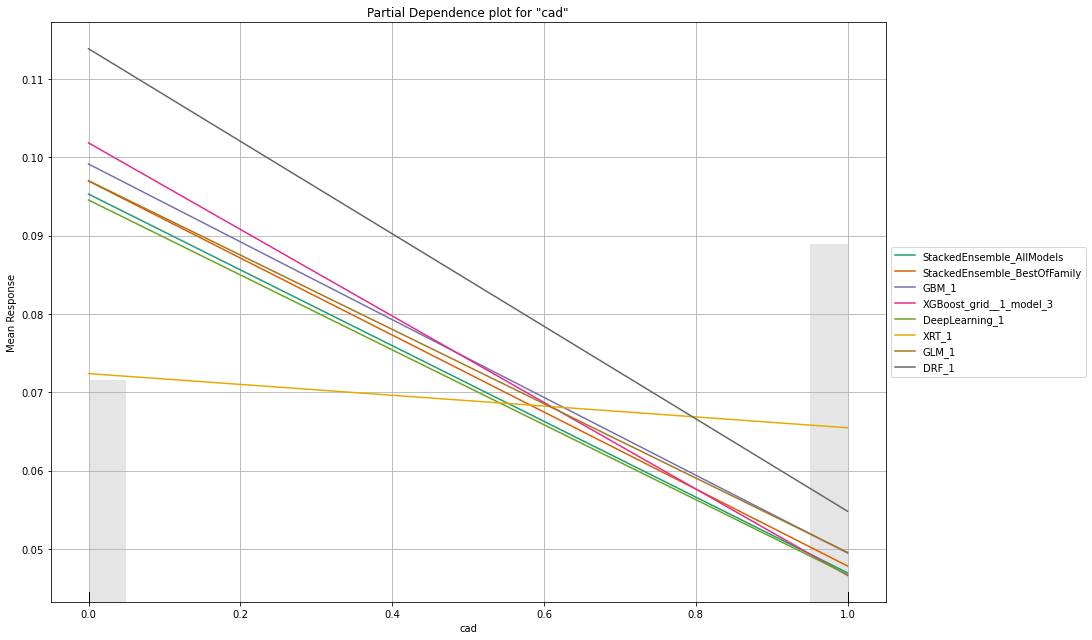

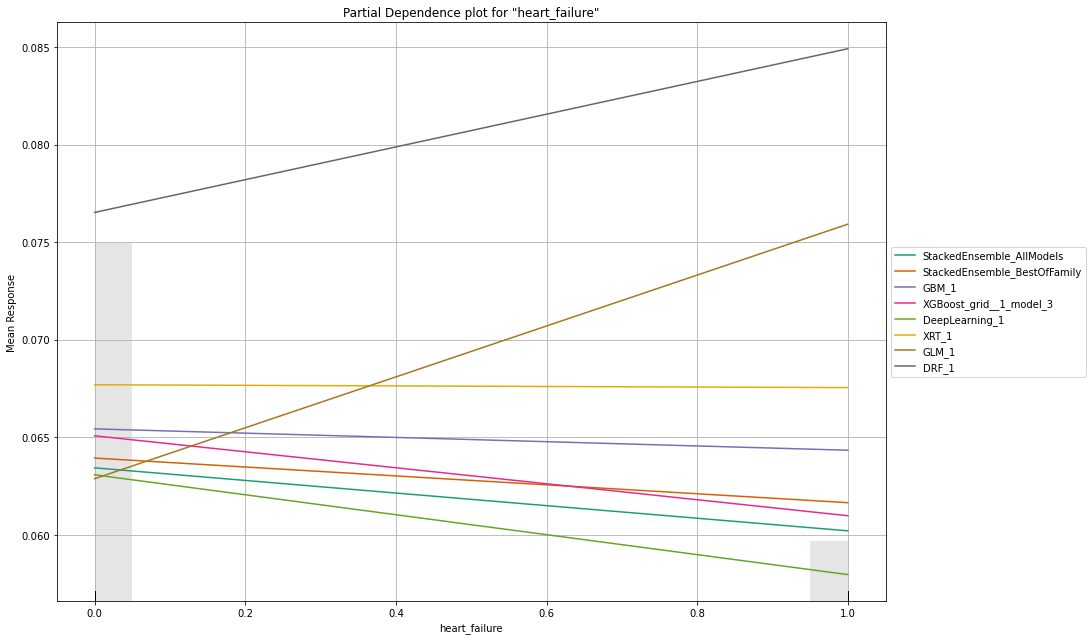

In [75]:
exa = aml.explain(test_data)

In [76]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20210421_175306

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.05357748094616957
RMSE: 0.23146809919764227
LogLoss: 0.19534087861507898
Null degrees of freedom: 10018
Residual degrees of freedom: 10005
Null deviance: 4887.215186958251
Residual deviance: 3914.240525688953
AIC: 3942.240525688953
AUC: 0.8371401962741398
AUCPR: 0.36490043518004767
Gini: 0.6742803925482797

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15239528842222444: 


,,0,1,Error,Rate
0,0,8889.0,466.0,0.0498,(466.0/9355.0)
1,1,386.0,278.0,0.5813,(386.0/664.0)
2,Total,9275.0,744.0,0.085,(852.0/10019.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.152395,0.394886,131.0
1,max f2,0.102617,0.472177,186.0
2,max f0point5,0.181486,0.423930,105.0
3,max accuracy,0.286561,0.938317,44.0
4,max precision,0.638036,1.000000,0.0
5,max recall,0.015345,1.000000,366.0
6,max specificity,0.638036,1.000000,0.0
7,max absolute_mcc,0.178795,0.351654,107.0
8,max min_per_class_accuracy,0.076382,0.749759,229.0
9,max mean_per_class_accuracy,0.071991,0.752069,238.0



Gains/Lift Table: Avg response rate:  6.63 %, avg score:  6.27 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010081,0.282382,10.905806,10.905806,0.722772,0.344384,0.722772,0.344384,0.109940,0.109940,990.580639,990.580639,0.106947
1,2,0.020062,0.234755,6.186431,8.557858,0.410000,0.255441,0.567164,0.300134,0.061747,0.171687,518.643072,755.785830,0.162387
2,3,0.030043,0.210921,5.733765,7.619621,0.380000,0.222862,0.504983,0.274462,0.057229,0.228916,473.376506,661.962134,0.212988
3,4,0.040024,0.192016,5.431988,7.074077,0.360000,0.200293,0.468828,0.255966,0.054217,0.283133,443.198795,607.407686,0.260364
4,5,0.050005,0.176535,5.130211,6.686080,0.340000,0.183469,0.443114,0.241496,0.051205,0.334337,413.021084,568.607965,0.304514
5,6,0.100010,0.132862,2.770808,4.728444,0.183633,0.152284,0.313373,0.196890,0.138554,0.472892,177.080778,372.844371,0.399348
6,7,0.150015,0.108359,2.138341,3.865076,0.141717,0.119849,0.256154,0.171210,0.106928,0.579819,113.834079,286.507607,0.460311
7,8,0.200020,0.093185,1.385404,3.245158,0.091816,0.100240,0.215070,0.153467,0.069277,0.649096,38.540389,224.515803,0.480951
8,9,0.300030,0.073436,1.204699,2.565005,0.079840,0.082369,0.169993,0.129768,0.120482,0.769578,20.469904,156.500503,0.502876
9,10,0.400040,0.059296,0.692702,2.096929,0.045908,0.066182,0.138972,0.113871,0.069277,0.838855,-30.729805,109.692926,0.469962




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.0579976137175978
RMSE: 0.240826937275708
LogLoss: 0.21859246520831152
Null degrees of freedom: 26449
Residual degrees of freedom: 26436
Null deviance: 12798.976472432048
Residual deviance: 11563.541409519676
AIC: 11591.541409519676
AUC: 0.737089624894253
AUCPR: 0.1690811121067709
Gini: 0.474179249788506

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12281628834160276: 


,,0,1,Error,Rate
0,0,21849.0,2868.0,0.116,(2868.0/24717.0)
1,1,1083.0,650.0,0.6249,(1083.0/1733.0)
2,Total,22932.0,3518.0,0.1494,(3951.0/26450.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.122816,0.247572,178.0
1,max f2,0.075022,0.359766,249.0
2,max f0point5,0.188225,0.228225,111.0
3,max accuracy,0.575284,0.934442,0.0
4,max precision,0.386967,0.392157,20.0
5,max recall,0.006519,1.000000,391.0
6,max specificity,0.575284,0.999960,0.0
7,max absolute_mcc,0.117946,0.189439,184.0
8,max min_per_class_accuracy,0.068649,0.665777,260.0
9,max mean_per_class_accuracy,0.075022,0.670511,249.0



Gains/Lift Table: Avg response rate:  6.55 %, avg score:  6.55 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010019,0.282089,4.837941,4.837941,0.316981,0.342055,0.316981,0.342055,0.048471,0.048471,383.794053,383.794053,0.041148
1,2,0.020000,0.237854,3.584387,4.212349,0.234848,0.256162,0.275992,0.299189,0.035776,0.084247,258.438686,321.234853,0.068752
2,3,0.030019,0.211542,3.686050,4.036695,0.241509,0.223276,0.264484,0.273853,0.036930,0.121177,268.604993,303.669471,0.097550
3,4,0.040000,0.193207,2.890635,3.750721,0.189394,0.202414,0.245747,0.256027,0.028852,0.150029,189.063456,275.072129,0.117743
4,5,0.050019,0.181830,3.282888,3.657013,0.215094,0.187215,0.239607,0.242244,0.032891,0.182920,228.288822,265.701323,0.142219
5,6,0.100000,0.139987,2.343644,3.000577,0.153555,0.158627,0.196597,0.200451,0.117138,0.300058,134.364429,200.057703,0.214084
6,7,0.150019,0.115198,2.088074,2.696333,0.136810,0.126557,0.176663,0.175814,0.104443,0.404501,108.807380,169.633263,0.272325
7,8,0.200000,0.098526,1.466221,2.388921,0.096067,0.106421,0.156522,0.158472,0.073283,0.477784,46.622081,138.892095,0.297261
8,9,0.300000,0.077246,1.327178,2.035007,0.086957,0.087023,0.133333,0.134656,0.132718,0.610502,32.717830,103.500673,0.332272
9,10,0.400000,0.062031,1.027121,1.783035,0.067297,0.069371,0.116824,0.118334,0.102712,0.713214,2.712060,78.303520,0.335175


In [77]:
aml.leader.model_performance(test_data)


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.058011987357743794
RMSE: 0.2408567776869561
LogLoss: 0.21975585195682776
Null degrees of freedom: 6612
Residual degrees of freedom: 6599
Null deviance: 3197.7723286579226
Residual deviance: 2906.490897981004
AIC: 2934.490897981004
AUC: 0.7290572658579789
AUCPR: 0.1716391242205254
Gini: 0.45811453171595784

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11715709066852593: 


,,0,1,Error,Rate
0,0,5534.0,646.0,0.1045,(646.0/6180.0)
1,1,277.0,156.0,0.6397,(277.0/433.0)
2,Total,5811.0,802.0,0.1396,(923.0/6613.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.117157,0.252632,147.0
1,max f2,0.073793,0.359050,221.0
2,max f0point5,0.187175,0.252069,78.0
3,max accuracy,0.370493,0.934523,5.0
4,max precision,0.370493,0.500000,5.0
5,max recall,0.004579,1.000000,391.0
6,max specificity,0.533120,0.999838,0.0
7,max absolute_mcc,0.117157,0.193792,147.0
8,max min_per_class_accuracy,0.066298,0.666667,237.0
9,max mean_per_class_accuracy,0.071944,0.669472,225.0



Gains/Lift Table: Avg response rate:  6.55 %, avg score:  6.11 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010132,0.255907,4.558960,4.558960,0.298507,0.303910,0.298507,0.303910,0.046189,0.046189,355.896039,355.896039,0.038584
1,2,0.020112,0.218366,4.859437,4.708069,0.318182,0.233719,0.308271,0.269078,0.048499,0.094688,385.943733,370.806925,0.079801
2,3,0.030092,0.193337,3.702428,4.374540,0.242424,0.204727,0.286432,0.247736,0.036952,0.131640,270.242844,337.454014,0.108662
3,4,0.040073,0.178535,3.933830,4.264778,0.257576,0.185403,0.279245,0.232211,0.039261,0.170901,293.383022,326.477842,0.139995
4,5,0.050053,0.168276,2.545420,3.921946,0.166667,0.173514,0.256798,0.220507,0.025404,0.196305,154.541955,292.194554,0.156499
5,6,0.100106,0.127485,2.076324,2.999135,0.135952,0.146314,0.196375,0.183411,0.103926,0.300231,107.632411,199.913482,0.214147
6,7,0.150008,0.105441,1.990055,2.663453,0.130303,0.115408,0.174395,0.160789,0.099307,0.399538,99.005529,166.345312,0.267014
7,8,0.200212,0.092548,1.472050,2.364702,0.096386,0.099045,0.154834,0.145306,0.073903,0.473441,47.204986,136.470246,0.292373
8,9,0.300015,0.074259,1.342130,2.024532,0.087879,0.082742,0.132560,0.124494,0.133949,0.607390,34.213031,102.453229,0.328911
9,10,0.399970,0.060191,0.924207,1.749555,0.060514,0.066909,0.114556,0.110103,0.092379,0.699769,-7.579320,74.955491,0.320805


# HAVOC

In [75]:


data_for_classificator = concatinate_array.drop(['sinus_rythm', 'TIA', 'CHA2DS2', 'left_heart', 'PAD', 'sex','age','cad','hyp','mass_index','heart_failure','diabetes','VD','stroke'], 1)

In [76]:
data_for_classificator

,havoc,y
54643,5,1
54160,4,1
111101,5,1
92144,5,1
144955,5,1
...,...,...
27875,2,0
76940,7,0
21605,3,0
76700,3,0


In [77]:
train_data, test_data = train_test_split(data_for_classificator,
                                         test_size=TEST_SIZE,
                                         stratify=data_for_classificator[TARGET_NAME],
                                         random_state=RANDOM_STATE)

In [78]:
logging.info('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

task = lightautoml.Task('binary', )

roles = {'target': TARGET_NAME,
         DatetimeRole(base_date=True, seasonality=(), base_feats=False): 'report_dt',
         }

automl = TabularAutoML(task = task,
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-04-16 16:43:30,003] (INFO): Data splitted. Parts sizes: train_data = (32365, 2), test_data = (8092, 2)


Start automl preset with listed constraints:
- time: 600 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (32365, 2)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 599.8402214050293 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6326627229771803
Linear model: C = 5e-05 score = 0.6326627229771803
Linear model: C = 0.0001 score = 0.6326627229771803

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6453698512032116
Linear model: C = 5e-05 score = 0.6453698512032116
Linear model: C = 0.0001 score = 0.6453698512032116

===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.6494034409974367
Linear model: C = 5e-05 score = 0.6494034409974367
Linear model: C = 0.0001 score = 0.6494034409974367

===== Start working with fol

[2021-04-16 16:43:33,602] (INFO): A new study created in memory with name: no-name-74d45439-20ad-44db-9a4a-67c377ebbdaa


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:33,927] (INFO): Trial 0 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.6352881457333674.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[1]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:34,343] (INFO): Trial 1 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.6352881457333674.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635276
Early stopping, best iteration is:
[42]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:34,686] (INFO): Trial 2 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[4]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:35,008] (INFO): Trial 3 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:35,338] (INFO): Trial 4 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[1]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:35,725] (INFO): Trial 5 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[1]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:36,087] (INFO): Trial 6 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:36,432] (INFO): Trial 7 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[16]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:36,783] (INFO): Trial 8 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[5]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:37,086] (INFO): Trial 9 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635276
Early stopping, best iteration is:
[54]	valid's auc: 0.636004
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:37,461] (INFO): Trial 10 finished with value: 0.6360044809103451 and parameters: {'feature_fraction': 0.8886185629157468, 'num_leaves': 89, 'bagging_fraction': 0.9847685553939332, 'min_sum_hessian_in_leaf': 0.001095687045466094, 'reg_alpha': 7.158478382247568, 'reg_lambda': 1.475649304728376}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[38]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:37,829] (INFO): Trial 11 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.9081201178672933, 'num_leaves': 252, 'bagging_fraction': 0.7261500350527624, 'min_sum_hessian_in_leaf': 0.001126240624595019, 'reg_alpha': 7.804075989965754, 'reg_lambda': 0.23538505092265555}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[1]	valid's auc: 0.636004
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:38,205] (INFO): Trial 12 finished with value: 0.6360044809103451 and parameters: {'feature_fraction': 0.9002673515004932, 'num_leaves': 187, 'bagging_fraction': 0.8354793185509454, 'min_sum_hessian_in_leaf': 0.001157172014043989, 'reg_alpha': 0.2773945772986779, 'reg_lambda': 0.5855213887055131}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.63525
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[29]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:38,539] (INFO): Trial 13 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.9039757416031456, 'num_leaves': 251, 'bagging_fraction': 0.6403079430369203, 'min_sum_hessian_in_leaf': 0.004719001005314561, 'reg_alpha': 8.582015977042417, 'reg_lambda': 0.013642878102327278}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636017
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:38,922] (INFO): Trial 14 finished with value: 0.6360165073318438 and parameters: {'feature_fraction': 0.8365941464916284, 'num_leaves': 181, 'bagging_fraction': 0.829574834342578, 'min_sum_hessian_in_leaf': 0.004686246415137018, 'reg_alpha': 0.1513416833915054, 'reg_lambda': 3.7931779551172298}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:39,288] (INFO): Trial 15 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9318637180348612, 'num_leaves': 188, 'bagging_fraction': 0.7483016145032468, 'min_sum_hessian_in_leaf': 0.00414318348737108, 'reg_alpha': 0.17183821663032375, 'reg_lambda': 0.0013127683122442903}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[47]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:39,693] (INFO): Trial 16 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.997521863264518, 'num_leaves': 254, 'bagging_fraction': 0.6740153964967152, 'min_sum_hessian_in_leaf': 7.1644313104393245, 'reg_alpha': 1.5320928573204893, 'reg_lambda': 0.1445115528384557}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:40,205] (INFO): Trial 17 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.8478248300112026, 'num_leaves': 61, 'bagging_fraction': 0.5406687945900464, 'min_sum_hessian_in_leaf': 0.005806441181895834, 'reg_alpha': 0.015217581103469546, 'reg_lambda': 3.409795523021241e-06}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[16]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:40,755] (INFO): Trial 18 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.647363321235647, 'num_leaves': 217, 'bagging_fraction': 0.6035571775986546, 'min_sum_hessian_in_leaf': 0.016639695460055785, 'reg_alpha': 1.1524023764269091, 'reg_lambda': 0.007645159361342289}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[1]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:41,345] (INFO): Trial 19 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9400358600511485, 'num_leaves': 171, 'bagging_fraction': 0.9919558944445384, 'min_sum_hessian_in_leaf': 0.002276897406759033, 'reg_alpha': 1.763024019441937e-05, 'reg_lambda': 0.0021069733329307254}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[16]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:41,999] (INFO): Trial 20 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.7708913414683156, 'num_leaves': 231, 'bagging_fraction': 0.6569438668403709, 'min_sum_hessian_in_leaf': 0.01992392865225242, 'reg_alpha': 0.013884671478083139, 'reg_lambda': 1.0668936396421777e-05}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[29]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:42,670] (INFO): Trial 21 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.8863192715939859, 'num_leaves': 253, 'bagging_fraction': 0.7843934204382036, 'min_sum_hessian_in_leaf': 0.0020448073062581816, 'reg_alpha': 5.568189331562408, 'reg_lambda': 0.10498001465496468}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[29]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:43,276] (INFO): Trial 22 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.8600980672500865, 'num_leaves': 255, 'bagging_fraction': 0.7910431581090791, 'min_sum_hessian_in_leaf': 0.002409069274977411, 'reg_alpha': 8.765685340206065, 'reg_lambda': 0.04507220947881128}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[29]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:43,862] (INFO): Trial 23 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.9110893273980865, 'num_leaves': 204, 'bagging_fraction': 0.6995849434246048, 'min_sum_hessian_in_leaf': 0.0066375202179391425, 'reg_alpha': 8.81675183064469, 'reg_lambda': 0.26550958416048487}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[7]	valid's auc: 0.636004
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:44,401] (INFO): Trial 24 finished with value: 0.6360044809103451 and parameters: {'feature_fraction': 0.8721680467762063, 'num_leaves': 235, 'bagging_fraction': 0.7786158256578287, 'min_sum_hessian_in_leaf': 0.0022068710888834032, 'reg_alpha': 0.9437115992973987, 'reg_lambda': 5.229975685260914}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:44,993] (INFO): Trial 25 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.8426882833963647, 'num_leaves': 238, 'bagging_fraction': 0.8833984163218369, 'min_sum_hessian_in_leaf': 0.0010702202228279915, 'reg_alpha': 0.0767069035737172, 'reg_lambda': 0.0670766806861148}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:45,533] (INFO): Trial 26 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.9413022507230995, 'num_leaves': 210, 'bagging_fraction': 0.6919130973856548, 'min_sum_hessian_in_leaf': 0.01255698981992165, 'reg_alpha': 0.6483798575066096, 'reg_lambda': 0.0018286645674039797}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.63525
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[29]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:46,081] (INFO): Trial 27 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.9643899566545868, 'num_leaves': 199, 'bagging_fraction': 0.6069721547279286, 'min_sum_hessian_in_leaf': 0.03852985242768385, 'reg_alpha': 9.448948303258316, 'reg_lambda': 0.006528276354706116}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636004
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:46,655] (INFO): Trial 28 finished with value: 0.6360044809103451 and parameters: {'feature_fraction': 0.8049949995448865, 'num_leaves': 172, 'bagging_fraction': 0.5670021447223501, 'min_sum_hessian_in_leaf': 0.008688004442145682, 'reg_alpha': 0.0033872005715802583, 'reg_lambda': 0.8184587953909435}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[27]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:47,228] (INFO): Trial 29 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.734861439691421, 'num_leaves': 111, 'bagging_fraction': 0.8365036148981326, 'min_sum_hessian_in_leaf': 0.03945848049639548, 'reg_alpha': 2.4850419052860064, 'reg_lambda': 0.0001668418374380445}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:47,793] (INFO): Trial 30 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.9560794262602162, 'num_leaves': 201, 'bagging_fraction': 0.6277706863621844, 'min_sum_hessian_in_leaf': 0.038695980872815, 'reg_alpha': 0.05367015303267145, 'reg_lambda': 0.00041196605621728836}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.63525
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[17]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:48,286] (INFO): Trial 31 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.9975849229075023, 'num_leaves': 255, 'bagging_fraction': 0.6016665053582442, 'min_sum_hessian_in_leaf': 0.0026895594825478183, 'reg_alpha': 7.984983681403069, 'reg_lambda': 0.0055847078166576065}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:48,860] (INFO): Trial 32 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.9977402669387564, 'num_leaves': 237, 'bagging_fraction': 0.5837717698626372, 'min_sum_hessian_in_leaf': 0.002597399501430937, 'reg_alpha': 0.5039539692730308, 'reg_lambda': 0.0045766256151880125}. Best is trial 2 with value: 0.6363376188906389.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.63525
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[30]	valid's auc: 0.636916
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:49,363] (INFO): Trial 33 finished with value: 0.6369162912225437 and parameters: {'feature_fraction': 0.9355003844087229, 'num_leaves': 228, 'bagging_fraction': 0.5342324278590496, 'min_sum_hessian_in_leaf': 0.008425649407096399, 'reg_alpha': 8.96198086675007, 'reg_lambda': 0.026244168726010337}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[34]	valid's auc: 0.636785
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:49,929] (INFO): Trial 34 finished with value: 0.6367854046860311 and parameters: {'feature_fraction': 0.9111299160217714, 'num_leaves': 225, 'bagging_fraction': 0.5083031254433301, 'min_sum_hessian_in_leaf': 0.008215640901833179, 'reg_alpha': 3.058890550084477, 'reg_lambda': 0.21210100716044616}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:50,488] (INFO): Trial 35 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.9202266240153767, 'num_leaves': 222, 'bagging_fraction': 0.5225993810385988, 'min_sum_hessian_in_leaf': 0.006969089210595235, 'reg_alpha': 2.8779659653945817, 'reg_lambda': 0.280038802437571}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[16]	valid's auc: 0.635602
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:51,023] (INFO): Trial 36 finished with value: 0.6356017484097041 and parameters: {'feature_fraction': 0.9256674463417868, 'num_leaves': 221, 'bagging_fraction': 0.5013913554101794, 'min_sum_hessian_in_leaf': 0.009684258387469646, 'reg_alpha': 2.4503551302586937, 'reg_lambda': 0.3634676597286202}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[4]	valid's auc: 0.63635
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:51,525] (INFO): Trial 37 finished with value: 0.6363496453121376 and parameters: {'feature_fraction': 0.5068250659078334, 'num_leaves': 222, 'bagging_fraction': 0.5350070839559162, 'min_sum_hessian_in_leaf': 0.020106852305857136, 'reg_alpha': 0.004901547813957604, 'reg_lambda': 8.339550304599076}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[4]	valid's auc: 0.63635
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:52,094] (INFO): Trial 38 finished with value: 0.6363496453121376 and parameters: {'feature_fraction': 0.5084476230738391, 'num_leaves': 168, 'bagging_fraction': 0.5241731229678598, 'min_sum_hessian_in_leaf': 0.025014579503463193, 'reg_alpha': 1.0280559173899637e-05, 'reg_lambda': 9.512095615343378}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[25]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:52,710] (INFO): Trial 39 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.666500196638472, 'num_leaves': 161, 'bagging_fraction': 0.5284527877477977, 'min_sum_hessian_in_leaf': 0.026808189915594607, 'reg_alpha': 9.213098344638141e-06, 'reg_lambda': 2.029047768153247}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636017
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:53,227] (INFO): Trial 40 finished with value: 0.6360165073318438 and parameters: {'feature_fraction': 0.5720429186371482, 'num_leaves': 129, 'bagging_fraction': 0.5576452785964108, 'min_sum_hessian_in_leaf': 0.0671310816611164, 'reg_alpha': 5.341461061397026e-06, 'reg_lambda': 1.9154307735840586}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[4]	valid's auc: 0.63635
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:53,738] (INFO): Trial 41 finished with value: 0.6363496453121376 and parameters: {'feature_fraction': 0.522590953005654, 'num_leaves': 223, 'bagging_fraction': 0.5057300267395257, 'min_sum_hessian_in_leaf': 0.06714215038888564, 'reg_alpha': 9.737151361383222e-05, 'reg_lambda': 8.181350363376698}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[4]	valid's auc: 0.63635
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:54,258] (INFO): Trial 42 finished with value: 0.6363496453121376 and parameters: {'feature_fraction': 0.5182277853752303, 'num_leaves': 193, 'bagging_fraction': 0.5072020157422094, 'min_sum_hessian_in_leaf': 0.30961422621755325, 'reg_alpha': 0.00021095966463739223, 'reg_lambda': 7.8143292207115405}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[4]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:54,771] (INFO): Trial 43 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.6059526505152647, 'num_leaves': 196, 'bagging_fraction': 0.5028588212813957, 'min_sum_hessian_in_leaf': 0.24038447644854954, 'reg_alpha': 0.0005516368573267983, 'reg_lambda': 0.034532659625285275}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:55,327] (INFO): Trial 44 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.5288506197586728, 'num_leaves': 223, 'bagging_fraction': 0.5041225443451648, 'min_sum_hessian_in_leaf': 0.6877829096795937, 'reg_alpha': 0.00025330323007832745, 'reg_lambda': 0.9869364010281975}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636017
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:55,845] (INFO): Trial 45 finished with value: 0.6360165073318438 and parameters: {'feature_fraction': 0.5582278370779228, 'num_leaves': 240, 'bagging_fraction': 0.5584158219962762, 'min_sum_hessian_in_leaf': 0.07766239265748302, 'reg_alpha': 7.45483146827875e-05, 'reg_lambda': 9.226214426484448}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636017
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:56,357] (INFO): Trial 46 finished with value: 0.6360165073318438 and parameters: {'feature_fraction': 0.6241670881374841, 'num_leaves': 205, 'bagging_fraction': 0.5018139128275633, 'min_sum_hessian_in_leaf': 0.17548320073131388, 'reg_alpha': 0.0013294494408854212, 'reg_lambda': 3.0912410072179894}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:56,861] (INFO): Trial 47 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.5474470822555016, 'num_leaves': 227, 'bagging_fraction': 0.574826572909323, 'min_sum_hessian_in_leaf': 0.4541039276462172, 'reg_alpha': 0.00019182679902777816, 'reg_lambda': 0.021355130789496454}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:57,387] (INFO): Trial 48 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.7046815413889509, 'num_leaves': 157, 'bagging_fraction': 0.5385411391987754, 'min_sum_hessian_in_leaf': 0.011819063433700622, 'reg_alpha': 1.4548562097019483e-07, 'reg_lambda': 0.11817302992898321}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[5]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:58,020] (INFO): Trial 49 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.8261581239723929, 'num_leaves': 186, 'bagging_fraction': 0.5219435925485474, 'min_sum_hessian_in_leaf': 1.1539985535300898, 'reg_alpha': 1.305789874724169e-06, 'reg_lambda': 0.3903871567395721}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:58,577] (INFO): Trial 50 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.786253328656142, 'num_leaves': 213, 'bagging_fraction': 0.5444891877378685, 'min_sum_hessian_in_leaf': 0.02470214299044544, 'reg_alpha': 1.2144646620683347e-06, 'reg_lambda': 0.8536428778986804}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[4]	valid's auc: 0.63635
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:59,171] (INFO): Trial 51 finished with value: 0.6363496453121376 and parameters: {'feature_fraction': 0.5102603212302216, 'num_leaves': 243, 'bagging_fraction': 0.5186427599425996, 'min_sum_hessian_in_leaf': 0.06287054207926254, 'reg_alpha': 0.004040606623893759, 'reg_lambda': 9.46799062304475}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[4]	valid's auc: 0.63635
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:43:59,720] (INFO): Trial 52 finished with value: 0.6363496453121376 and parameters: {'feature_fraction': 0.5874250516953827, 'num_leaves': 241, 'bagging_fraction': 0.530194379350083, 'min_sum_hessian_in_leaf': 0.00764951934573699, 'reg_alpha': 1.919014848829865e-08, 'reg_lambda': 9.478745959293997}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636017
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:00,268] (INFO): Trial 53 finished with value: 0.6360165073318438 and parameters: {'feature_fraction': 0.5005701608772086, 'num_leaves': 245, 'bagging_fraction': 0.5546253087355942, 'min_sum_hessian_in_leaf': 0.014136383933618567, 'reg_alpha': 0.005023443071057944, 'reg_lambda': 2.3878238547039343}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:00,759] (INFO): Trial 54 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.5794505834756548, 'num_leaves': 248, 'bagging_fraction': 0.585181677902096, 'min_sum_hessian_in_leaf': 0.0034989982793784892, 'reg_alpha': 0.3798139716730171, 'reg_lambda': 0.24141261874269063}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:01,258] (INFO): Trial 55 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.5473387737962554, 'num_leaves': 230, 'bagging_fraction': 0.517823632051225, 'min_sum_hessian_in_leaf': 0.36008061489978066, 'reg_alpha': 0.07910807303861575, 'reg_lambda': 0.5371010601433218}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636017
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:01,781] (INFO): Trial 56 finished with value: 0.6360165073318438 and parameters: {'feature_fraction': 0.9771253240510441, 'num_leaves': 191, 'bagging_fraction': 0.6222954073575815, 'min_sum_hessian_in_leaf': 0.007379073650758927, 'reg_alpha': 2.0220967802445036e-08, 'reg_lambda': 3.8567500468286884}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:02,260] (INFO): Trial 57 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.8832580035546733, 'num_leaves': 241, 'bagging_fraction': 0.5459561526800553, 'min_sum_hessian_in_leaf': 0.05875067423190019, 'reg_alpha': 3.7438491742074893, 'reg_lambda': 1.304493123108968}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[32]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:02,871] (INFO): Trial 58 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.8726815877658906, 'num_leaves': 175, 'bagging_fraction': 0.5406906560160705, 'min_sum_hessian_in_leaf': 0.023071615346478856, 'reg_alpha': 2.4356621257350057, 'reg_lambda': 0.1410297086022459}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636004
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:03,389] (INFO): Trial 59 finished with value: 0.6360044809103451 and parameters: {'feature_fraction': 0.949774237489072, 'num_leaves': 212, 'bagging_fraction': 0.5688573569974523, 'min_sum_hessian_in_leaf': 0.12059630596081107, 'reg_alpha': 5.71577906028205e-05, 'reg_lambda': 1.2614641580117203}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[4]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:03,907] (INFO): Trial 60 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9145462700425132, 'num_leaves': 217, 'bagging_fraction': 0.5050447541499163, 'min_sum_hessian_in_leaf': 0.08561072546109681, 'reg_alpha': 0.0005463524148426989, 'reg_lambda': 0.06131147351710216}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[4]	valid's auc: 0.636017
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:04,390] (INFO): Trial 61 finished with value: 0.6360165073318438 and parameters: {'feature_fraction': 0.882759988742789, 'num_leaves': 208, 'bagging_fraction': 0.5237765926978196, 'min_sum_hessian_in_leaf': 0.04856191928277316, 'reg_alpha': 9.546787887159443e-06, 'reg_lambda': 6.4974796970539}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[39]	valid's auc: 0.636785
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:04,919] (INFO): Trial 62 finished with value: 0.6367854046860311 and parameters: {'feature_fraction': 0.5252938235318185, 'num_leaves': 225, 'bagging_fraction': 0.5498739971136303, 'min_sum_hessian_in_leaf': 0.17493288648080718, 'reg_alpha': 3.9187008829959162, 'reg_lambda': 3.7612926654600684e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:05,415] (INFO): Trial 63 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.9326293658013648, 'num_leaves': 243, 'bagging_fraction': 0.5929744203220775, 'min_sum_hessian_in_leaf': 0.0016021993225210096, 'reg_alpha': 0.22217816532084414, 'reg_lambda': 4.503663497053183e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636797
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:05,933] (INFO): Trial 64 finished with value: 0.6367973700597047 and parameters: {'feature_fraction': 0.9001315413611456, 'num_leaves': 132, 'bagging_fraction': 0.5551675598819851, 'min_sum_hessian_in_leaf': 0.005710627201851821, 'reg_alpha': 1.1085743571079228e-08, 'reg_lambda': 2.0486229458567932e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:06,434] (INFO): Trial 65 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.8956141493043094, 'num_leaves': 142, 'bagging_fraction': 0.5508799727889757, 'min_sum_hessian_in_leaf': 0.005317558764090516, 'reg_alpha': 1.9935221912551532e-08, 'reg_lambda': 4.8028429344754076e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[15]	valid's auc: 0.636004
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:06,887] (INFO): Trial 66 finished with value: 0.6360044809103451 and parameters: {'feature_fraction': 0.8247922987564743, 'num_leaves': 124, 'bagging_fraction': 0.6211157286960012, 'min_sum_hessian_in_leaf': 0.2689821161808387, 'reg_alpha': 3.1680790332470528, 'reg_lambda': 2.6522829729260755e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:07,362] (INFO): Trial 67 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.9201515404878579, 'num_leaves': 84, 'bagging_fraction': 0.5698484563818202, 'min_sum_hessian_in_leaf': 0.1611783522038952, 'reg_alpha': 4.546740983049959, 'reg_lambda': 4.0463976573917886e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635264
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:07,840] (INFO): Trial 68 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.9192673392092724, 'num_leaves': 52, 'bagging_fraction': 0.5693674811496018, 'min_sum_hessian_in_leaf': 0.17202007682210155, 'reg_alpha': 4.667672551463225, 'reg_lambda': 3.380055729880733e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:08,432] (INFO): Trial 69 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.9594726325401415, 'num_leaves': 88, 'bagging_fraction': 0.6072675884417832, 'min_sum_hessian_in_leaf': 0.18478352641049442, 'reg_alpha': 0.7967515087753039, 'reg_lambda': 1.1743028418427122e-06}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:08,929] (INFO): Trial 70 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.9180309591633177, 'num_leaves': 60, 'bagging_fraction': 0.5763106597817722, 'min_sum_hessian_in_leaf': 0.16312356006138462, 'reg_alpha': 5.219991342028349, 'reg_lambda': 2.7157942070396846e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:09,458] (INFO): Trial 71 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.8628861891719616, 'num_leaves': 51, 'bagging_fraction': 0.6401409520085201, 'min_sum_hessian_in_leaf': 0.11767884200961269, 'reg_alpha': 1.1828364005073477, 'reg_lambda': 9.369712005266551e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:09,928] (INFO): Trial 72 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.9155720220630572, 'num_leaves': 45, 'bagging_fraction': 0.5737547591862951, 'min_sum_hessian_in_leaf': 0.18085836699675778, 'reg_alpha': 4.4478641723915455, 'reg_lambda': 1.7797696236972035e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:10,384] (INFO): Trial 73 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.9031278689030274, 'num_leaves': 17, 'bagging_fraction': 0.5826587026948662, 'min_sum_hessian_in_leaf': 0.20957482451346057, 'reg_alpha': 5.707525472470884, 'reg_lambda': 1.267401907905749e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[18]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:10,870] (INFO): Trial 74 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.8978231629577124, 'num_leaves': 19, 'bagging_fraction': 0.5917661218185926, 'min_sum_hessian_in_leaf': 0.6835233903508336, 'reg_alpha': 1.6143038673787455, 'reg_lambda': 1.0638927153652927e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:11,329] (INFO): Trial 75 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.9441085254284349, 'num_leaves': 50, 'bagging_fraction': 0.5702993826971312, 'min_sum_hessian_in_leaf': 0.15597134035441731, 'reg_alpha': 4.558894676391982, 'reg_lambda': 1.3288897974750856e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[16]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:11,842] (INFO): Trial 76 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9452072115423857, 'num_leaves': 73, 'bagging_fraction': 0.6619196317040225, 'min_sum_hessian_in_leaf': 0.003769233551049493, 'reg_alpha': 0.451319975738739, 'reg_lambda': 1.723933377691881e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.63525
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[15]	valid's auc: 0.63635
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:12,267] (INFO): Trial 77 finished with value: 0.6363496453121376 and parameters: {'feature_fraction': 0.9748421796459289, 'num_leaves': 34, 'bagging_fraction': 0.565493587474389, 'min_sum_hessian_in_leaf': 0.09474192948750466, 'reg_alpha': 9.63679591184412, 'reg_lambda': 2.392073635532128e-05}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[16]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:12,748] (INFO): Trial 78 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9272958883565776, 'num_leaves': 72, 'bagging_fraction': 0.5983677399831451, 'min_sum_hessian_in_leaf': 0.22663079324312083, 'reg_alpha': 1.4245043655893388, 'reg_lambda': 5.319432526504678e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:13,267] (INFO): Trial 79 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.8745277046589817, 'num_leaves': 20, 'bagging_fraction': 0.5488740290148255, 'min_sum_hessian_in_leaf': 0.3472567602972407, 'reg_alpha': 4.161476558549267, 'reg_lambda': 8.277022195474744e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.63525
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[15]	valid's auc: 0.63635
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:13,676] (INFO): Trial 80 finished with value: 0.6363496453121376 and parameters: {'feature_fraction': 0.8568043052218407, 'num_leaves': 103, 'bagging_fraction': 0.5545797378176239, 'min_sum_hessian_in_leaf': 0.39845692229808066, 'reg_alpha': 9.609024007704216, 'reg_lambda': 4.3339633885445135e-06}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:14,152] (INFO): Trial 81 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.9057661883155075, 'num_leaves': 38, 'bagging_fraction': 0.5812665497263798, 'min_sum_hessian_in_leaf': 0.5465617304313373, 'reg_alpha': 5.475031265781158, 'reg_lambda': 1.088159786840556e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:14,622] (INFO): Trial 82 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.9041379405211802, 'num_leaves': 37, 'bagging_fraction': 0.6099674020563071, 'min_sum_hessian_in_leaf': 0.5794137916131445, 'reg_alpha': 0.8154916027676464, 'reg_lambda': 1.0896663897644814e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[30]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:15,115] (INFO): Trial 83 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9233053296903869, 'num_leaves': 71, 'bagging_fraction': 0.5284095799016915, 'min_sum_hessian_in_leaf': 0.010733287822809266, 'reg_alpha': 2.0516015862409507, 'reg_lambda': 3.5336426057244184e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[29]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:15,575] (INFO): Trial 84 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.9147006459342383, 'num_leaves': 46, 'bagging_fraction': 0.6366883780277455, 'min_sum_hessian_in_leaf': 0.20029259348330014, 'reg_alpha': 5.572077261486401, 'reg_lambda': 2.3226725533107008e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.63525
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[29]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:16,052] (INFO): Trial 85 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.9392162690899984, 'num_leaves': 16, 'bagging_fraction': 0.5873678989778357, 'min_sum_hessian_in_leaf': 2.583728397113127, 'reg_alpha': 9.130758724978273, 'reg_lambda': 1.0762939317912658e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:16,544] (INFO): Trial 86 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.8789473755410511, 'num_leaves': 60, 'bagging_fraction': 0.5383091283728415, 'min_sum_hessian_in_leaf': 0.13960453292158828, 'reg_alpha': 3.48315290845392, 'reg_lambda': 6.563762941204764e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[31]	valid's auc: 0.636797
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:17,110] (INFO): Trial 87 finished with value: 0.6367973700597047 and parameters: {'feature_fraction': 0.9547389833164706, 'num_leaves': 104, 'bagging_fraction': 0.5654284880674245, 'min_sum_hessian_in_leaf': 0.1092288257803554, 'reg_alpha': 1.736751887312419, 'reg_lambda': 3.5977173349508274e-06}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[5]	valid's auc: 0.636364
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:17,571] (INFO): Trial 88 finished with value: 0.6363639305031561 and parameters: {'feature_fraction': 0.9651146300732647, 'num_leaves': 110, 'bagging_fraction': 0.5147556092882795, 'min_sum_hessian_in_leaf': 0.005694757621505368, 'reg_alpha': 1.520112631112883, 'reg_lambda': 2.2730099340707655e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:18,072] (INFO): Trial 89 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.8916958327418832, 'num_leaves': 125, 'bagging_fraction': 0.5377644808804369, 'min_sum_hessian_in_leaf': 0.9647389116520845, 'reg_alpha': 0.11385940069811838, 'reg_lambda': 0.0006648711421891054}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:18,571] (INFO): Trial 90 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9909301480455608, 'num_leaves': 26, 'bagging_fraction': 0.5519920825786332, 'min_sum_hessian_in_leaf': 0.003048841525191121, 'reg_alpha': 0.03674222612126269, 'reg_lambda': 5.349588662725603e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[32]	valid's auc: 0.636797
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:19,065] (INFO): Trial 91 finished with value: 0.6367973700597047 and parameters: {'feature_fraction': 0.953241924103585, 'num_leaves': 235, 'bagging_fraction': 0.5447826937407587, 'min_sum_hessian_in_leaf': 0.2571370048469221, 'reg_alpha': 2.744673391754477, 'reg_lambda': 8.325143552212461e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:19,537] (INFO): Trial 92 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.954469677958937, 'num_leaves': 103, 'bagging_fraction': 0.5626304745097971, 'min_sum_hessian_in_leaf': 0.054133357886038014, 'reg_alpha': 0.6119315612991202, 'reg_lambda': 2.0821634680969037e-06}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[27]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:20,026] (INFO): Trial 93 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9773277157999406, 'num_leaves': 93, 'bagging_fraction': 0.5147099451512926, 'min_sum_hessian_in_leaf': 0.27301693019558393, 'reg_alpha': 2.1652573259063415, 'reg_lambda': 4.65303243367761e-06}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636043
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:20,511] (INFO): Trial 94 finished with value: 0.6360427578965362 and parameters: {'feature_fraction': 0.8673708898540012, 'num_leaves': 24, 'bagging_fraction': 0.5480722884956846, 'min_sum_hessian_in_leaf': 0.47389379609220833, 'reg_alpha': 0.24790394977211988, 'reg_lambda': 1.0075769440637345e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636031
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:20,987] (INFO): Trial 95 finished with value: 0.6360307925228623 and parameters: {'feature_fraction': 0.9356736858756369, 'num_leaves': 234, 'bagging_fraction': 0.5677278203600601, 'min_sum_hessian_in_leaf': 0.1052295680093505, 'reg_alpha': 0.9437188105932484, 'reg_lambda': 1.8703234025724432e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[32]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:21,472] (INFO): Trial 96 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.9080121456409104, 'num_leaves': 39, 'bagging_fraction': 0.533208367387013, 'min_sum_hessian_in_leaf': 0.13163560486564974, 'reg_alpha': 2.568899459544916, 'reg_lambda': 3.808993737279962e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[2]	valid's auc: 0.636043
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:21,956] (INFO): Trial 97 finished with value: 0.6360427578965362 and parameters: {'feature_fraction': 0.9499207966095753, 'num_leaves': 118, 'bagging_fraction': 0.5498323674524979, 'min_sum_hessian_in_leaf': 0.08106368381936317, 'reg_alpha': 0.32689090575090723, 'reg_lambda': 7.220074487558128e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[30]	valid's auc: 0.636759
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:22,420] (INFO): Trial 98 finished with value: 0.6367590930735139 and parameters: {'feature_fraction': 0.9004939143034975, 'num_leaves': 138, 'bagging_fraction': 0.5778717320064869, 'min_sum_hessian_in_leaf': 0.8978565275769689, 'reg_alpha': 6.877220752032878, 'reg_lambda': 2.594280275463057e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635276
[200]	valid's auc: 0.635264
Early stopping, best iteration is:
[17]	valid's auc: 0.636338
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:22,844] (INFO): Trial 99 finished with value: 0.6363376188906389 and parameters: {'feature_fraction': 0.8529162453976223, 'num_leaves': 134, 'bagging_fraction': 0.5871799439132563, 'min_sum_hessian_in_leaf': 2.260425770923735, 'reg_alpha': 7.293572678073732, 'reg_lambda': 3.182668194286804e-08}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.635288
[200]	valid's auc: 0.635288
Early stopping, best iteration is:
[34]	valid's auc: 0.635288
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-16 16:44:23,337] (INFO): Trial 100 finished with value: 0.6352881457333674 and parameters: {'feature_fraction': 0.8862819660575354, 'num_leaves': 160, 'bagging_fraction': 0.5308698549290584, 'min_sum_hessian_in_leaf': 0.004544619390507837, 'reg_alpha': 2.90125725747166, 'reg_lambda': 6.909530337053083e-07}. Best is trial 33 with value: 0.6369162912225437.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.635216
Early stopping, best iteration is:
[30]	valid's auc: 0.636759

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.641796
Early stopping, best iteration is:
[3]	valid's auc: 0.641862

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.649894
Early stopping, best iteration is:
[94]	valid's auc: 0.649894

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.640158
Early stopping, best iteration is:
[14]	valid's auc: 0.64225

===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Ligh

[2021-04-16 16:44:31,374] (INFO): A new study created in memory with name: no-name-d39325cf-1704-444d-94b7-958ebe2ed2e7


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 11.5ms	remaining: 57.5s
100:	test: 0.6329741	best: 0.6330063 (3)	total: 1.09s	remaining: 52.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 3

Shrink model to first 4 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:32,597] (INFO): Trial 0 finished with value: 0.6330063001355262 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.6330063001355262.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 11.4ms	remaining: 57.2s
100:	test: 0.6329741	best: 0.6340729 (69)	total: 1.05s	remaining: 50.8s
200:	test: 0.6352881	best: 0.6367974 (134)	total: 2.02s	remaining: 48.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 134

Shrink model to first 135 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:35,085] (INFO): Trial 1 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0023531598052637494, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6180233	best: 0.6180233 (0)	total: 11.8ms	remaining: 58.9s
100:	test: 0.6329741	best: 0.6329741 (5)	total: 940ms	remaining: 45.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:36,181] (INFO): Trial 2 finished with value: 0.6329740668839969 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0001359064372443865, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6180233	best: 0.6180233 (0)	total: 12.3ms	remaining: 1m 1s
100:	test: 0.6329741	best: 0.6329741 (5)	total: 1s	remaining: 48.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:37,341] (INFO): Trial 3 finished with value: 0.6329740668839969 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.5ms	remaining: 52.4s
100:	test: 0.6329741	best: 0.6330063 (3)	total: 1.01s	remaining: 49.2s
200:	test: 0.6367974	best: 0.6367974 (130)	total: 1.93s	remaining: 46.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 130

Shrink model to first 131 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:39,669] (INFO): Trial 4 finished with value: 0.6367973700597047 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.798816213712645, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.7ms	remaining: 53.5s
100:	test: 0.6329741	best: 0.6341052 (2)	total: 1.05s	remaining: 51.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.634105161
bestIteration = 2

Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:40,843] (INFO): Trial 5 finished with value: 0.6341051609831141 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6173182	best: 0.6173182 (0)	total: 10.5ms	remaining: 52.7s
100:	test: 0.6329741	best: 0.6335453 (3)	total: 1000ms	remaining: 48.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6335452914
bestIteration = 3

Shrink model to first 4 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:41,984] (INFO): Trial 6 finished with value: 0.633545291381268 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6119756	best: 0.6119756 (0)	total: 9.68ms	remaining: 48.4s
100:	test: 0.6329741	best: 0.6329741 (49)	total: 1.2s	remaining: 58.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 49

Shrink model to first 50 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:43,933] (INFO): Trial 7 finished with value: 0.6329740668839969 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 11.5ms	remaining: 57.3s
100:	test: 0.6329741	best: 0.6341052 (5)	total: 1.24s	remaining: 1m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.634105161
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:45,345] (INFO): Trial 8 finished with value: 0.6341051609831141 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.804965855340144, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6180233	best: 0.6180233 (0)	total: 13.7ms	remaining: 1m 8s
100:	test: 0.6329741	best: 0.6329741 (5)	total: 1.08s	remaining: 52.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:46,594] (INFO): Trial 9 finished with value: 0.6329740668839969 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.767947964358124e-05, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.1ms	remaining: 50.3s
100:	test: 0.6329741	best: 0.6340729 (42)	total: 1.05s	remaining: 50.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6340729277
bestIteration = 42

Shrink model to first 43 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:48,192] (INFO): Trial 10 finished with value: 0.6340729277315849 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.019901008687711098, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.4ms	remaining: 52s
100:	test: 0.6329741	best: 0.6340729 (54)	total: 935ms	remaining: 45.4s
200:	test: 0.6352881	best: 0.6367974 (135)	total: 1.83s	remaining: 43.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 135

Shrink model to first 136 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:50,455] (INFO): Trial 11 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.15009291623242751, 'min_data_in_leaf': 5}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 9.61ms	remaining: 48s
100:	test: 0.6340729	best: 0.6340729 (99)	total: 944ms	remaining: 45.8s
200:	test: 0.6352881	best: 0.6367974 (143)	total: 1.85s	remaining: 44.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 143

Shrink model to first 144 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:52,811] (INFO): Trial 12 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.010743840129434608, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 8.94ms	remaining: 44.7s
100:	test: 0.6329741	best: 0.6329741 (4)	total: 977ms	remaining: 47.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:53,938] (INFO): Trial 13 finished with value: 0.6329740668839969 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.7560182433876121, 'min_data_in_leaf': 8}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 11.1ms	remaining: 55.7s
100:	test: 0.6340729	best: 0.6340729 (83)	total: 960ms	remaining: 46.5s
200:	test: 0.6352881	best: 0.6367974 (153)	total: 1.85s	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 153

Shrink model to first 154 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:56,389] (INFO): Trial 14 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.004422543156548659, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.4ms	remaining: 51.8s
100:	test: 0.6329741	best: 0.6329741 (5)	total: 934ms	remaining: 45.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:57,484] (INFO): Trial 15 finished with value: 0.6329740668839969 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.21046760561620978, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6173182	best: 0.6173182 (0)	total: 8.79ms	remaining: 43.9s
100:	test: 0.6329741	best: 0.6329741 (18)	total: 884ms	remaining: 42.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 18

Shrink model to first 19 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:44:58,628] (INFO): Trial 16 finished with value: 0.6329740668839969 and parameters: {'max_depth': 4, 'l2_leaf_reg': 9.181026419164905, 'min_data_in_leaf': 7}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.4ms	remaining: 52.2s
100:	test: 0.6329741	best: 0.6340729 (69)	total: 965ms	remaining: 46.8s
200:	test: 0.6352881	best: 0.6367974 (134)	total: 1.94s	remaining: 46.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 134

Shrink model to first 135 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:01,049] (INFO): Trial 17 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0025695638307028476, 'min_data_in_leaf': 18}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.1ms	remaining: 50.4s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 955ms	remaining: 46.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:02,170] (INFO): Trial 18 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0012357783441216531, 'min_data_in_leaf': 18}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.3ms	remaining: 51.4s
100:	test: 0.6340729	best: 0.6340729 (42)	total: 955ms	remaining: 46.3s
200:	test: 0.6352881	best: 0.6367974 (129)	total: 1.85s	remaining: 44.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 129

Shrink model to first 130 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:04,416] (INFO): Trial 19 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.024120005384608553, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6173182	best: 0.6173182 (0)	total: 9.19ms	remaining: 45.9s
100:	test: 0.6329741	best: 0.6329943 (4)	total: 898ms	remaining: 43.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329943348
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:05,466] (INFO): Trial 20 finished with value: 0.6329943347618523 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.04353528180127789, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.6ms	remaining: 52.8s
100:	test: 0.6329741	best: 0.6341052 (2)	total: 1.04s	remaining: 50.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.634105161
bestIteration = 2

Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:06,648] (INFO): Trial 21 finished with value: 0.6341051609831141 and parameters: {'max_depth': 6, 'l2_leaf_reg': 7.357979541151468e-05, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 9.88ms	remaining: 49.4s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1s	remaining: 48.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:07,799] (INFO): Trial 22 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0014864022442428121, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.6ms	remaining: 52.8s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 958ms	remaining: 46.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:08,911] (INFO): Trial 23 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.17715164012850884, 'min_data_in_leaf': 5}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 9.71ms	remaining: 48.5s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 952ms	remaining: 46.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:10,016] (INFO): Trial 24 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.08136558919668718, 'min_data_in_leaf': 9}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.3ms	remaining: 51.4s
100:	test: 0.6329741	best: 0.6340729 (5)	total: 952ms	remaining: 46.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6340729277
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:11,129] (INFO): Trial 25 finished with value: 0.6340729277315849 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.1470931897123111, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.6ms	remaining: 53s
100:	test: 0.6329741	best: 0.6340729 (90)	total: 1.02s	remaining: 49.4s
200:	test: 0.6352881	best: 0.6367974 (139)	total: 2.06s	remaining: 49.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 139

Shrink model to first 140 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:13,839] (INFO): Trial 26 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.00861909012416838, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 18.3ms	remaining: 1m 31s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.37s	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:15,452] (INFO): Trial 27 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.007984360701020836, 'min_data_in_leaf': 13}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 13.5ms	remaining: 1m 7s
100:	test: 0.6329741	best: 0.6340729 (69)	total: 1.55s	remaining: 1m 15s
200:	test: 0.6352881	best: 0.6367974 (134)	total: 2.81s	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 134

Shrink model to first 135 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:18,838] (INFO): Trial 28 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.002469777041512058, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 13.4ms	remaining: 1m 7s
100:	test: 0.6329741	best: 0.6341052 (2)	total: 1.31s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.634105161
bestIteration = 2

Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:20,307] (INFO): Trial 29 finished with value: 0.6341051609831141 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0002371095567745066, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6119756	best: 0.6119756 (0)	total: 8.26ms	remaining: 41.3s
100:	test: 0.6329741	best: 0.6329741 (49)	total: 988ms	remaining: 47.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 49

Shrink model to first 50 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:21,863] (INFO): Trial 30 finished with value: 0.6329740668839969 and parameters: {'max_depth': 3, 'l2_leaf_reg': 2.7511162251906275e-05, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.5ms	remaining: 1m 2s
100:	test: 0.6340729	best: 0.6340729 (42)	total: 1.24s	remaining: 1m
200:	test: 0.6352881	best: 0.6367974 (127)	total: 2.32s	remaining: 55.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 127

Shrink model to first 128 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:24,630] (INFO): Trial 31 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.014899156649786307, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.6ms	remaining: 52.8s
100:	test: 0.6329741	best: 0.6340729 (69)	total: 1.16s	remaining: 56.2s
200:	test: 0.6352881	best: 0.6367974 (134)	total: 2.23s	remaining: 53.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 134

Shrink model to first 135 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:27,345] (INFO): Trial 32 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.002552299179973975, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 9.49ms	remaining: 47.4s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 996ms	remaining: 48.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:28,493] (INFO): Trial 33 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.000557332929165461, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6180233	best: 0.6180233 (0)	total: 8.86ms	remaining: 44.3s
100:	test: 0.6340729	best: 0.6342504 (3)	total: 1.01s	remaining: 48.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6342503938
bestIteration = 3

Shrink model to first 4 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:29,646] (INFO): Trial 34 finished with value: 0.6342503937584703 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.0392116931881197, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.1ms	remaining: 50.5s
100:	test: 0.6340729	best: 0.6341052 (2)	total: 1.11s	remaining: 53.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.634105161
bestIteration = 2

Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:30,893] (INFO): Trial 35 finished with value: 0.6341051609831141 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0017220675706325992, 'min_data_in_leaf': 18}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.9ms	remaining: 54.3s
100:	test: 0.6329741	best: 0.6341052 (2)	total: 1.03s	remaining: 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.634105161
bestIteration = 2

Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:32,066] (INFO): Trial 36 finished with value: 0.6341051609831141 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.00014620395277116066, 'min_data_in_leaf': 18}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6180233	best: 0.6180233 (0)	total: 9.09ms	remaining: 45.4s
100:	test: 0.6340729	best: 0.6342301 (2)	total: 1.08s	remaining: 52.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6342301259
bestIteration = 2

Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:33,290] (INFO): Trial 37 finished with value: 0.6342301258806148 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.4098165544538524, 'min_data_in_leaf': 6}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.6ms	remaining: 53.2s
100:	test: 0.6340729	best: 0.6340932 (5)	total: 1.05s	remaining: 51.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6340931956
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:34,501] (INFO): Trial 38 finished with value: 0.6340931956094404 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.05304765244170213, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 9.91ms	remaining: 49.6s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1s	remaining: 48.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:35,669] (INFO): Trial 39 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.00649400962483059, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 9.68ms	remaining: 48.4s
100:	test: 0.6340729	best: 0.6340729 (42)	total: 1.09s	remaining: 52.8s
200:	test: 0.6352881	best: 0.6367974 (129)	total: 2.14s	remaining: 51.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 129

Shrink model to first 130 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:38,258] (INFO): Trial 40 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.024076752951937085, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 9.39ms	remaining: 46.9s
100:	test: 0.6340729	best: 0.6340729 (49)	total: 1.08s	remaining: 52.6s
200:	test: 0.6352881	best: 0.6367974 (122)	total: 2.28s	remaining: 54.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 122

Shrink model to first 123 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:40,995] (INFO): Trial 41 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.025489519964573687, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 14.1ms	remaining: 1m 10s
100:	test: 0.6340729	best: 0.6340729 (42)	total: 1.47s	remaining: 1m 11s
200:	test: 0.6352881	best: 0.6367974 (116)	total: 2.82s	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 116

Shrink model to first 117 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:44,247] (INFO): Trial 42 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.027321935092287395, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 24.5ms	remaining: 2m 2s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.38s	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:45,885] (INFO): Trial 43 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0060052038696717935, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 15.5ms	remaining: 1m 17s
100:	test: 0.6329741	best: 0.6341052 (2)	total: 1.46s	remaining: 1m 10s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.634105161
bestIteration = 2

Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:47,509] (INFO): Trial 44 finished with value: 0.6341051609831141 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.569950917245284e-07, 'min_data_in_leaf': 9}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.5ms	remaining: 1m 2s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.35s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:49,036] (INFO): Trial 45 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.00043999158448558177, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 11.1ms	remaining: 55.3s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.27s	remaining: 1m 1s
200:	test: 0.6352881	best: 0.6367974 (136)	total: 2.5s	remaining: 59.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 136

Shrink model to first 137 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:52,088] (INFO): Trial 46 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.01424638157329786, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.5ms	remaining: 1m 2s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.25s	remaining: 1m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:53,513] (INFO): Trial 47 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0008357602196919753, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.6ms	remaining: 1m 2s
100:	test: 0.6329741	best: 0.6340729 (69)	total: 1.24s	remaining: 1m
200:	test: 0.6352881	best: 0.6367974 (134)	total: 2.44s	remaining: 58.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 134

Shrink model to first 135 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:56,484] (INFO): Trial 48 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.002409352426626535, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.5ms	remaining: 1m 2s
100:	test: 0.6329741	best: 0.6341052 (2)	total: 1.11s	remaining: 54.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.634105161
bestIteration = 2

Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:57,737] (INFO): Trial 49 finished with value: 0.6341051609831141 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.804702880456065e-05, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.9ms	remaining: 54.4s
100:	test: 0.6329741	best: 0.6330063 (3)	total: 1.09s	remaining: 53.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 3

Shrink model to first 4 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:45:58,983] (INFO): Trial 50 finished with value: 0.6330063001355262 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.256967710790777, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.1ms	remaining: 50.3s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.12s	remaining: 54.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:00,281] (INFO): Trial 51 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.003203471033965108, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.4ms	remaining: 1m 1s
100:	test: 0.6340729	best: 0.6340729 (56)	total: 1.16s	remaining: 56.4s
200:	test: 0.6352881	best: 0.6367974 (115)	total: 2.29s	remaining: 54.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 115

Shrink model to first 116 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:02,876] (INFO): Trial 52 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.039839067930537674, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.6ms	remaining: 1m 2s
100:	test: 0.6329741	best: 0.6340729 (42)	total: 1.14s	remaining: 55.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6340729277
bestIteration = 42

Shrink model to first 43 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:04,635] (INFO): Trial 53 finished with value: 0.6340729277315849 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.01781104852895485, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 13ms	remaining: 1m 5s
100:	test: 0.6340729	best: 0.6340729 (83)	total: 1.12s	remaining: 54.4s
200:	test: 0.6352881	best: 0.6367974 (153)	total: 2.26s	remaining: 53.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 153

Shrink model to first 154 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:07,597] (INFO): Trial 54 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.004418288159820795, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.6ms	remaining: 52.8s
100:	test: 0.6329741	best: 0.6340729 (18)	total: 1.14s	remaining: 55.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6340729277
bestIteration = 18

Shrink model to first 19 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:09,103] (INFO): Trial 55 finished with value: 0.6340729277315849 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.07112805075535572, 'min_data_in_leaf': 13}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12ms	remaining: 59.9s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.31s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:10,595] (INFO): Trial 56 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.14717534169065485, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 9.97ms	remaining: 49.8s
100:	test: 0.6329741	best: 0.6329741 (6)	total: 1.12s	remaining: 54.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 6

Shrink model to first 7 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:11,910] (INFO): Trial 57 finished with value: 0.6329740668839969 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.49242191182629624, 'min_data_in_leaf': 8}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.3ms	remaining: 51.5s
100:	test: 0.6329741	best: 0.6330063 (3)	total: 1.18s	remaining: 57.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 3

Shrink model to first 4 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:13,252] (INFO): Trial 58 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.03481631369214598, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.5ms	remaining: 52.6s
100:	test: 0.6340729	best: 0.6340729 (86)	total: 1.12s	remaining: 54.6s
200:	test: 0.6352881	best: 0.6367974 (133)	total: 2.17s	remaining: 51.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 133

Shrink model to first 134 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:15,905] (INFO): Trial 59 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.09244171382763504, 'min_data_in_leaf': 9}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.7ms	remaining: 53.4s
100:	test: 0.6329741	best: 0.6341052 (2)	total: 1.22s	remaining: 59.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.634105161
bestIteration = 2

Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:17,284] (INFO): Trial 60 finished with value: 0.6341051609831141 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.0009174162365905254, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.4ms	remaining: 1m 2s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.3s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:18,802] (INFO): Trial 61 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.08307261488279766, 'min_data_in_leaf': 9}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 13.2ms	remaining: 1m 6s
100:	test: 0.6340729	best: 0.6340729 (98)	total: 1.36s	remaining: 1m 6s
200:	test: 0.6352881	best: 0.6367974 (137)	total: 2.42s	remaining: 57.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 137

Shrink model to first 138 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:21,766] (INFO): Trial 62 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.030908026734812223, 'min_data_in_leaf': 13}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.4ms	remaining: 52.1s
100:	test: 0.6340729	best: 0.6340729 (56)	total: 1.16s	remaining: 56.4s
200:	test: 0.6352881	best: 0.6367974 (126)	total: 2.52s	remaining: 1m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 126

Shrink model to first 127 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:24,749] (INFO): Trial 63 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.013624486588122962, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 13.7ms	remaining: 1m 8s
100:	test: 0.6329741	best: 0.6329741 (8)	total: 1.34s	remaining: 1m 5s
200:	test: 0.6352881	best: 0.6367974 (140)	total: 2.75s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 140

Shrink model to first 141 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:28,151] (INFO): Trial 64 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.19578489394712362, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.9ms	remaining: 1m 4s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.28s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:29,603] (INFO): Trial 65 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.005882701620725681, 'min_data_in_leaf': 13}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6173182	best: 0.6173182 (0)	total: 9.05ms	remaining: 45.2s
100:	test: 0.6329741	best: 0.6329741 (32)	total: 1.26s	remaining: 1m 1s
200:	test: 0.6367974	best: 0.6367974 (182)	total: 2.36s	remaining: 56.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 182

Shrink model to first 183 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:33,007] (INFO): Trial 66 finished with value: 0.6367973700597047 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.2883047727075242, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6173182	best: 0.6173182 (0)	total: 16.3ms	remaining: 1m 21s
100:	test: 0.6340729	best: 0.6340729 (67)	total: 1.56s	remaining: 1m 15s
200:	test: 0.6367974	best: 0.6367974 (155)	total: 2.74s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 155

Shrink model to first 156 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:36,561] (INFO): Trial 67 finished with value: 0.6367973700597047 and parameters: {'max_depth': 4, 'l2_leaf_reg': 1.1989508652831402, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6119756	best: 0.6119756 (0)	total: 11.3ms	remaining: 56.5s
100:	test: 0.6329741	best: 0.6343408 (4)	total: 1.27s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6343408056
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:38,018] (INFO): Trial 68 finished with value: 0.6343408055870969 and parameters: {'max_depth': 3, 'l2_leaf_reg': 1.4722798328103945, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6173182	best: 0.6173182 (0)	total: 10.4ms	remaining: 51.8s
100:	test: 0.6340729	best: 0.6342301 (15)	total: 1.34s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6342301259
bestIteration = 15

Shrink model to first 16 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:39,671] (INFO): Trial 69 finished with value: 0.6342301258806148 and parameters: {'max_depth': 4, 'l2_leaf_reg': 8.225059897047707, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 18.9ms	remaining: 1m 34s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.58s	remaining: 1m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:41,455] (INFO): Trial 70 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0032622840522744403, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 13.7ms	remaining: 1m 8s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.35s	remaining: 1m 5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:42,994] (INFO): Trial 71 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0018864621725472417, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.5ms	remaining: 1m 2s
100:	test: 0.6340729	best: 0.6340729 (31)	total: 1.55s	remaining: 1m 15s
200:	test: 0.6352881	best: 0.6367974 (116)	total: 3.04s	remaining: 1m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 116

Shrink model to first 117 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:46,421] (INFO): Trial 72 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.10079145626746812, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 14.3ms	remaining: 1m 11s
100:	test: 0.6340729	best: 0.6340729 (67)	total: 1.53s	remaining: 1m 14s
200:	test: 0.6352881	best: 0.6367974 (130)	total: 2.87s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 130

Shrink model to first 131 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:49,835] (INFO): Trial 73 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.00981142592703033, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 13.5ms	remaining: 1m 7s
100:	test: 0.6340729	best: 0.6340729 (67)	total: 1.37s	remaining: 1m 6s
200:	test: 0.6352881	best: 0.6367974 (128)	total: 2.57s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 128

Shrink model to first 129 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:52,912] (INFO): Trial 74 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.011648974496025323, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 13.9ms	remaining: 1m 9s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.52s	remaining: 1m 13s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:54,637] (INFO): Trial 75 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.011749387711928965, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 15.9ms	remaining: 1m 19s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.4s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:56,245] (INFO): Trial 76 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.04583958053533625, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.4ms	remaining: 1m 2s
100:	test: 0.6340729	best: 0.6340729 (72)	total: 1.32s	remaining: 1m 4s
200:	test: 0.6352881	best: 0.6367974 (136)	total: 2.51s	remaining: 1m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 136

Shrink model to first 137 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:46:59,371] (INFO): Trial 77 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.030187964063505587, 'min_data_in_leaf': 13}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 11.4ms	remaining: 57.1s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.34s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:00,897] (INFO): Trial 78 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.00029131030660593175, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 14.1ms	remaining: 1m 10s
100:	test: 0.6329741	best: 0.6340729 (42)	total: 1.39s	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6340729277
bestIteration = 42

Shrink model to first 43 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:02,916] (INFO): Trial 79 finished with value: 0.6340729277315849 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.018828532597766037, 'min_data_in_leaf': 13}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6173182	best: 0.6173182 (0)	total: 10.2ms	remaining: 50.7s
100:	test: 0.6329741	best: 0.6342504 (4)	total: 1.03s	remaining: 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6342503938
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:04,128] (INFO): Trial 80 finished with value: 0.6342503937584703 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.31254549233169787, 'min_data_in_leaf': 18}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 11ms	remaining: 55.2s
100:	test: 0.6329741	best: 0.6340729 (42)	total: 1.13s	remaining: 54.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6340729277
bestIteration = 42

Shrink model to first 43 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:05,809] (INFO): Trial 81 finished with value: 0.6340729277315849 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.02227215649801942, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.2ms	remaining: 1m
100:	test: 0.6340729	best: 0.6340729 (100)	total: 1.15s	remaining: 55.7s
200:	test: 0.6352881	best: 0.6367974 (139)	total: 2.28s	remaining: 54.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 139

Shrink model to first 140 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:08,746] (INFO): Trial 82 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.002081415942162101, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.2ms	remaining: 1m 1s
100:	test: 0.6340729	best: 0.6340729 (83)	total: 1.32s	remaining: 1m 4s
200:	test: 0.6352881	best: 0.6367974 (134)	total: 2.59s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 134

Shrink model to first 135 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:11,965] (INFO): Trial 83 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.004952868498746046, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 14.2ms	remaining: 1m 11s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.44s	remaining: 1m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:13,612] (INFO): Trial 84 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0015976939627094415, 'min_data_in_leaf': 8}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6180233	best: 0.6180233 (0)	total: 10.7ms	remaining: 53.5s
100:	test: 0.6329741	best: 0.6342182 (2)	total: 1.42s	remaining: 1m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6342181605
bestIteration = 2

Shrink model to first 3 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:15,220] (INFO): Trial 85 finished with value: 0.6342181605069411 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.693209323743891, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 14.2ms	remaining: 1m 11s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.24s	remaining: 1m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:16,662] (INFO): Trial 86 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0006680171666976793, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 20.1ms	remaining: 1m 40s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.32s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:18,189] (INFO): Trial 87 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.09494115391759693, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 11ms	remaining: 54.9s
100:	test: 0.6329741	best: 0.6340932 (5)	total: 1.08s	remaining: 52.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6340931956
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:19,443] (INFO): Trial 88 finished with value: 0.6340931956094404 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.008694136231892512, 'min_data_in_leaf': 9}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6173182	best: 0.6173182 (0)	total: 10.8ms	remaining: 54s
100:	test: 0.6329741	best: 0.6329741 (25)	total: 1.14s	remaining: 55.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 25

Shrink model to first 26 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:20,964] (INFO): Trial 89 finished with value: 0.6329740668839969 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.27143044135198535, 'min_data_in_leaf': 14}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 11.8ms	remaining: 58.9s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.18s	remaining: 57.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:22,333] (INFO): Trial 90 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.012477776769282077, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12ms	remaining: 1m
100:	test: 0.6340729	best: 0.6340729 (42)	total: 1.18s	remaining: 57.3s
200:	test: 0.6352881	best: 0.6367974 (116)	total: 2.58s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 116

Shrink model to first 117 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:25,282] (INFO): Trial 91 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.026548054843351758, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 11.5ms	remaining: 57.5s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.28s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:26,744] (INFO): Trial 92 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.05514329800118078, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.5ms	remaining: 1m 2s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.12s	remaining: 54.4s
200:	test: 0.6352881	best: 0.6367974 (136)	total: 2.12s	remaining: 50.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 136

Shrink model to first 137 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:29,383] (INFO): Trial 93 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.014228708909313275, 'min_data_in_leaf': 1}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.6ms	remaining: 53.1s
100:	test: 0.6340729	best: 0.6340729 (83)	total: 1.17s	remaining: 56.8s
200:	test: 0.6352881	best: 0.6367974 (127)	total: 2.47s	remaining: 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 127

Shrink model to first 128 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:32,368] (INFO): Trial 94 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0036511962626580236, 'min_data_in_leaf': 7}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6180233	best: 0.6180233 (0)	total: 10.8ms	remaining: 54.2s
100:	test: 0.6329741	best: 0.6329741 (5)	total: 1.16s	remaining: 56.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 5

Shrink model to first 6 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:33,722] (INFO): Trial 95 finished with value: 0.6329740668839969 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0011120577655515725, 'min_data_in_leaf': 7}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6173182	best: 0.6173182 (0)	total: 8.58ms	remaining: 42.9s
100:	test: 0.6329741	best: 0.6329921 (1)	total: 1.22s	remaining: 59.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.632992137
bestIteration = 1

Shrink model to first 2 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:35,081] (INFO): Trial 96 finished with value: 0.6329921370401572 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.8471144929637999, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.3ms	remaining: 1m 1s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.16s	remaining: 56.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:36,417] (INFO): Trial 97 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.006941112926287228, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6119756	best: 0.6119756 (0)	total: 11.3ms	remaining: 56.3s
100:	test: 0.6329741	best: 0.6329741 (49)	total: 1.06s	remaining: 51.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6329740669
bestIteration = 49

Shrink model to first 50 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:38,084] (INFO): Trial 98 finished with value: 0.6329740668839969 and parameters: {'max_depth': 3, 'l2_leaf_reg': 0.000183131983057648, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.7ms	remaining: 1m 3s
100:	test: 0.6329741	best: 0.6330063 (4)	total: 1.15s	remaining: 55.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6330063001
bestIteration = 4

Shrink model to first 5 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:39,411] (INFO): Trial 99 finished with value: 0.6330063001355262 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.000415067492490494, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 10.2ms	remaining: 51.2s
100:	test: 0.6340729	best: 0.6340729 (83)	total: 1.17s	remaining: 56.7s
200:	test: 0.6352881	best: 0.6367974 (134)	total: 2.27s	remaining: 54.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 134

Shrink model to first 135 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-16 16:47:42,203] (INFO): Trial 100 finished with value: 0.6367973700597047 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.005088517626686444, 'min_data_in_leaf': 12}. Best is trial 1 with value: 0.6367973700597047.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6188668	best: 0.6188668 (0)	total: 12.4ms	remaining: 37.2s
100:	test: 0.6329741	best: 0.6340729 (69)	total: 1.2s	remaining: 34.4s
200:	test: 0.6352881	best: 0.6367974 (134)	total: 2.43s	remaining: 33.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6367973701
bestIteration = 134

Shrink model to first 135 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6214520	best: 0.6214520 (0)	total: 11.4ms	remaining: 34.1s
100:	test: 0.6435409	best: 0.6454511 (5)	total: 1.23s	remaining: 35.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6454511369
bestIteration = 5

Shrink model to first 6 iterations.

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6248799	best: 0.6248799 (0)	total: 14.5ms	remaining: 43.4s
100:	test: 0.6494110	best: 0.6494110 (5

[2021-04-16 16:47:52,397] (INFO): oof_pred:
array([[0.26615694],
       [0.27308166],
       [0.26179206],
       ...,
       [0.26615694],
       [0.26178354],
       [0.28672114]], dtype=float32)
Shape = (32365, 1)
[2021-04-16 16:47:52,523] (INFO): Prediction for test data:
array([[0.26128352],
       [0.28614745],
       [0.26582265],
       ...,
       [0.29668358],
       [0.26128352],
       [0.26128352]], dtype=float32)
Shape = (8092, 1)
[2021-04-16 16:47:52,525] (INFO): Check scores...
[2021-04-16 16:47:52,551] (INFO): OOF score: 0.6429095025970967
[2021-04-16 16:47:52,560] (INFO): TEST score: 0.6325044285409507


# HAVOC's features in our model

In [27]:

data_for_classificator = concatinate_array.drop(['havoc','sinus_rythm', 'TIA', 'CHA2DS2', 'left_heart', 'sex','diabetes','stroke'], 1)

In [29]:
data_for_classificator.columns

Index(['PI48', 'age', 'cad', 'hyp', 'mass_index', 'heart_failure', 'VD', 'PAD', 'y'], dtype='object')

In [6]:
train_data, test_data = train_test_split(data_for_classificator,
                                         test_size=TEST_SIZE,
                                         stratify=data_for_classificator[TARGET_NAME],
                                         random_state=RANDOM_STATE)

In [7]:
logging.info('Data splitted. Parts sizes: train_data = {}, test_data = {}'
              .format(train_data.shape, test_data.shape))

task = lightautoml.Task('binary', )

roles = {'target': TARGET_NAME,
         DatetimeRole(base_date=True, seasonality=(), base_feats=False): 'report_dt',
         }

automl = TabularAutoML(task = task,
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                      )
oof_pred = automl.fit_predict(train_data, roles = roles)
logging.info('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

test_pred = automl.predict(test_data)
logging.info('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

logging.info('Check scores...')
logging.info('OOF score: {}'.format(roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])))
logging.info('TEST score: {}'.format(roc_auc_score(test_data[TARGET_NAME].values, test_pred.data[:, 0])))

[2021-04-19 18:04:51,678] (INFO): Data splitted. Parts sizes: train_data = (32365, 8), test_data = (8092, 8)
Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 600 seconds
- cpus: 8 cores
- memory: 16 gb

Train data shape: (32365, 8)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 584.061231136322 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model: C = 1e-05 score = 0.716976301234387
Linear model: C = 5e-05 score = 0.7201504218404698
Linear model: C = 0.0001 score = 0.7219396114916425
Linear model: C = 0.0005 score = 0.7246815134976742
Linear model: C = 0.001 score = 0.7253219051805184
Linear model: C = 0.005 score = 0.7265658156599881
Linear model: C = 0.01 score = 0.7269900980428068
Linear model: C = 0.05 score = 0.7269896096602078
Linear model: C = 0.1 score = 0.7278805416163022
Linear model: C = 0.5 score = 0.7278805416163022
Linear model: C = 1 score = 0.7278805416163022

===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====

Linear model

[2021-04-19 18:05:25,035] (INFO): A new study created in memory with name: no-name-736027f8-6e78-4b2d-a97c-18ba47b12a73


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737005
[200]	valid's auc: 0.733826
Early stopping, best iteration is:
[40]	valid's auc: 0.739027
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:26,966] (INFO): Trial 0 finished with value: 0.7390267145281614 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 108, 'bagging_fraction': 0.5917173949330818, 'min_sum_hessian_in_leaf': 1.3145103232150122, 'reg_alpha': 0.0023531598052637494, 'reg_lambda': 0.00010291881465670109}. Best is trial 0 with value: 0.7390267145281614.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.733765
[200]	valid's auc: 0.731431
Early stopping, best iteration is:
[67]	valid's auc: 0.734961
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:29,836] (INFO): Trial 1 finished with value: 0.734960868344261 and parameters: {'feature_fraction': 0.5499874579090014, 'num_leaves': 218, 'bagging_fraction': 0.9330880728874675, 'min_sum_hessian_in_leaf': 0.2537815508265665, 'reg_alpha': 0.023585940584142682, 'reg_lambda': 1.5320059381854043e-08}. Best is trial 0 with value: 0.7390267145281614.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.732895
[200]	valid's auc: 0.73514
[300]	valid's auc: 0.735513
[400]	valid's auc: 0.735728
[500]	valid's auc: 0.735909
[600]	valid's auc: 0.735991
[700]	valid's auc: 0.735983
[800]	valid's auc: 0.735983
Early stopping, best iteration is:
[628]	valid's auc: 0.736008
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:33,786] (INFO): Trial 2 finished with value: 0.7360083879711365 and parameters: {'feature_fraction': 0.9849549260809971, 'num_leaves': 251, 'bagging_fraction': 0.9692763545078751, 'min_sum_hessian_in_leaf': 0.0010071984838809194, 'reg_alpha': 8.509499823666633, 'reg_lambda': 0.0036085571407386235}. Best is trial 0 with value: 0.7390267145281614.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.730585
[200]	valid's auc: 0.722877
Early stopping, best iteration is:
[39]	valid's auc: 0.734575
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:36,938] (INFO): Trial 3 finished with value: 0.7345749850432829 and parameters: {'feature_fraction': 0.8058265802441404, 'num_leaves': 251, 'bagging_fraction': 0.5115312125207079, 'min_sum_hessian_in_leaf': 0.12563152773938666, 'reg_alpha': 3.9696182670988566e-05, 'reg_lambda': 2.630213296503227e-08}. Best is trial 0 with value: 0.7390267145281614.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738155
[200]	valid's auc: 0.737463
Early stopping, best iteration is:
[96]	valid's auc: 0.738339
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:38,289] (INFO): Trial 4 finished with value: 0.7383387665897465 and parameters: {'feature_fraction': 0.9868777594207296, 'num_leaves': 30, 'bagging_fraction': 0.728034992108518, 'min_sum_hessian_in_leaf': 1.382623217936987, 'reg_alpha': 6.267062696005991e-07, 'reg_lambda': 0.00042472707398058225}. Best is trial 0 with value: 0.7390267145281614.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.734308
[200]	valid's auc: 0.729364
Early stopping, best iteration is:
[30]	valid's auc: 0.736591
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:41,217] (INFO): Trial 5 finished with value: 0.7365910894594825 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 146, 'bagging_fraction': 0.9299702033681603, 'min_sum_hessian_in_leaf': 0.5262961031076743, 'reg_alpha': 0.00011336872639641431, 'reg_lambda': 1.316390230170444e-08}. Best is trial 0 with value: 0.7390267145281614.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738486
[200]	valid's auc: 0.737851
Early stopping, best iteration is:
[98]	valid's auc: 0.738572
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:42,833] (INFO): Trial 6 finished with value: 0.7385714808981356 and parameters: {'feature_fraction': 0.9711008778424264, 'num_leaves': 29, 'bagging_fraction': 0.9041986740582306, 'min_sum_hessian_in_leaf': 0.01653693718282442, 'reg_alpha': 7.569183361880229e-08, 'reg_lambda': 0.014391207615728067}. Best is trial 0 with value: 0.7390267145281614.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.734247
[200]	valid's auc: 0.729112
Early stopping, best iteration is:
[38]	valid's auc: 0.73713
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:46,607] (INFO): Trial 7 finished with value: 0.7371304469921737 and parameters: {'feature_fraction': 0.7200762468698007, 'num_leaves': 214, 'bagging_fraction': 0.8049983288913105, 'min_sum_hessian_in_leaf': 2.1516897298083326, 'reg_alpha': 3.6331378936352306e-07, 'reg_lambda': 3.307847415252541e-05}. Best is trial 0 with value: 0.7390267145281614.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.736465
[200]	valid's auc: 0.734847
Early stopping, best iteration is:
[96]	valid's auc: 0.736654
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:49,135] (INFO): Trial 8 finished with value: 0.7366539687190945 and parameters: {'feature_fraction': 0.5911180438940311, 'num_leaves': 147, 'bagging_fraction': 0.6558555380447055, 'min_sum_hessian_in_leaf': 0.12030178871154672, 'reg_alpha': 0.0008325158565947976, 'reg_lambda': 4.609885087947832e-07}. Best is trial 0 with value: 0.7390267145281614.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.731906
[200]	valid's auc: 0.730162
[300]	valid's auc: 0.728486
Early stopping, best iteration is:
[112]	valid's auc: 0.732109
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:52,439] (INFO): Trial 9 finished with value: 0.7321084697752218 and parameters: {'feature_fraction': 0.9847923138822793, 'num_leaves': 233, 'bagging_fraction': 0.7248770666848828, 'min_sum_hessian_in_leaf': 0.03807158379249393, 'reg_alpha': 2.1874079799487576, 'reg_lambda': 0.0351113851431067}. Best is trial 0 with value: 0.7390267145281614.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738425
[200]	valid's auc: 0.735561
Early stopping, best iteration is:
[91]	valid's auc: 0.739038
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:54,405] (INFO): Trial 10 finished with value: 0.7390381304714113 and parameters: {'feature_fraction': 0.6591377620440741, 'num_leaves': 92, 'bagging_fraction': 0.5023623641678501, 'min_sum_hessian_in_leaf': 6.037016369049049, 'reg_alpha': 0.044629157407987986, 'reg_lambda': 6.350520386779478e-06}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.73862
[200]	valid's auc: 0.737193
Early stopping, best iteration is:
[91]	valid's auc: 0.738954
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:56,263] (INFO): Trial 11 finished with value: 0.7389540676165708 and parameters: {'feature_fraction': 0.6734307400766498, 'num_leaves': 78, 'bagging_fraction': 0.5018055470485477, 'min_sum_hessian_in_leaf': 9.980585382555322, 'reg_alpha': 0.0752551628201671, 'reg_lambda': 7.650079634768741e-06}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737435
[200]	valid's auc: 0.737043
[300]	valid's auc: 0.734118
Early stopping, best iteration is:
[153]	valid's auc: 0.737952
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:05:58,950] (INFO): Trial 12 finished with value: 0.7379519675713954 and parameters: {'feature_fraction': 0.6347818693744313, 'num_leaves': 94, 'bagging_fraction': 0.6065450039008404, 'min_sum_hessian_in_leaf': 7.132731717981334, 'reg_alpha': 0.01629363588656633, 'reg_lambda': 3.42440655706267e-06}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.735355
[200]	valid's auc: 0.73461
[300]	valid's auc: 0.733247
Early stopping, best iteration is:
[129]	valid's auc: 0.735703
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:01,516] (INFO): Trial 13 finished with value: 0.735703454085931 and parameters: {'feature_fraction': 0.8595101921818923, 'num_leaves': 86, 'bagging_fraction': 0.5722204162781267, 'min_sum_hessian_in_leaf': 3.461551230853909, 'reg_alpha': 0.563243585320909, 'reg_lambda': 4.588492805253924}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737006
[200]	valid's auc: 0.735905
[300]	valid's auc: 0.732628
Early stopping, best iteration is:
[133]	valid's auc: 0.737485
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:04,055] (INFO): Trial 14 finished with value: 0.73748519590247 and parameters: {'feature_fraction': 0.5031268390636299, 'num_leaves': 118, 'bagging_fraction': 0.5529195452691984, 'min_sum_hessian_in_leaf': 0.8918765729131236, 'reg_alpha': 0.001399145497777228, 'reg_lambda': 0.0001398089383758705}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.73656
[200]	valid's auc: 0.732277
Early stopping, best iteration is:
[42]	valid's auc: 0.737964
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:06,528] (INFO): Trial 15 finished with value: 0.7379646044711428 and parameters: {'feature_fraction': 0.7006315295202941, 'num_leaves': 163, 'bagging_fraction': 0.6465850560141302, 'min_sum_hessian_in_leaf': 8.295467885955897, 'reg_alpha': 8.827446426671855e-06, 'reg_lambda': 4.778488743614888e-07}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.735903
[200]	valid's auc: 0.734149
Early stopping, best iteration is:
[42]	valid's auc: 0.736206
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:08,634] (INFO): Trial 16 finished with value: 0.7362059997802278 and parameters: {'feature_fraction': 0.6236524948451638, 'num_leaves': 182, 'bagging_fraction': 0.524679671841891, 'min_sum_hessian_in_leaf': 4.443546197590034, 'reg_alpha': 0.003947243942700033, 'reg_lambda': 0.2234372437704238}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738365
[200]	valid's auc: 0.737681
[300]	valid's auc: 0.736534
Early stopping, best iteration is:
[128]	valid's auc: 0.738448
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:10,437] (INFO): Trial 17 finished with value: 0.7384476759093073 and parameters: {'feature_fraction': 0.7630718849226144, 'num_leaves': 53, 'bagging_fraction': 0.8129989624132342, 'min_sum_hessian_in_leaf': 0.42286119734249233, 'reg_alpha': 0.160788723036386, 'reg_lambda': 0.0008084735562630859}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.735525
[200]	valid's auc: 0.73173
Early stopping, best iteration is:
[42]	valid's auc: 0.737692
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:12,319] (INFO): Trial 18 finished with value: 0.7376920259331161 and parameters: {'feature_fraction': 0.8626232813873017, 'num_leaves': 114, 'bagging_fraction': 0.6570595327136735, 'min_sum_hessian_in_leaf': 0.0049411334304856995, 'reg_alpha': 0.004747687777371463, 'reg_lambda': 4.063820709508292e-07}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738473
[200]	valid's auc: 0.738114
[300]	valid's auc: 0.736503
Early stopping, best iteration is:
[142]	valid's auc: 0.738955
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:14,466] (INFO): Trial 19 finished with value: 0.7389551054295935 and parameters: {'feature_fraction': 0.5461024289713107, 'num_leaves': 59, 'bagging_fraction': 0.6055452925027422, 'min_sum_hessian_in_leaf': 1.6580725437625046, 'reg_alpha': 1.3392878624235952e-05, 'reg_lambda': 3.87802837329146e-05}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.736396
[200]	valid's auc: 0.732775
Early stopping, best iteration is:
[42]	valid's auc: 0.738576
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:19,012] (INFO): Trial 20 finished with value: 0.7385763647241249 and parameters: {'feature_fraction': 0.6520677745687661, 'num_leaves': 111, 'bagging_fraction': 0.5678667132505447, 'min_sum_hessian_in_leaf': 3.348982380645839, 'reg_alpha': 0.0003377879198139377, 'reg_lambda': 4.219748022685308e-06}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738436
[200]	valid's auc: 0.737878
[300]	valid's auc: 0.736162
Early stopping, best iteration is:
[142]	valid's auc: 0.738735
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:22,781] (INFO): Trial 21 finished with value: 0.7387346006861776 and parameters: {'feature_fraction': 0.5163137475141635, 'num_leaves': 59, 'bagging_fraction': 0.6064103201129508, 'min_sum_hessian_in_leaf': 1.3078179156416503, 'reg_alpha': 9.249966530709201e-06, 'reg_lambda': 5.149573835862479e-05}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738063
[200]	valid's auc: 0.73762
[300]	valid's auc: 0.736412
Early stopping, best iteration is:
[133]	valid's auc: 0.73831
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:26,379] (INFO): Trial 22 finished with value: 0.7383100741120593 and parameters: {'feature_fraction': 0.5758715300808022, 'num_leaves': 63, 'bagging_fraction': 0.6908574557492934, 'min_sum_hessian_in_leaf': 0.7846817485599145, 'reg_alpha': 2.748700918765153e-05, 'reg_lambda': 1.9471588891100977e-05}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738306
[200]	valid's auc: 0.737277
Early stopping, best iteration is:
[42]	valid's auc: 0.738646
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:29,122] (INFO): Trial 23 finished with value: 0.7386457761009976 and parameters: {'feature_fraction': 0.7055891916288373, 'num_leaves': 43, 'bagging_fraction': 0.6095757716652243, 'min_sum_hessian_in_leaf': 0.3234178101664077, 'reg_alpha': 1.6556943642120667e-06, 'reg_lambda': 0.0012449486921011427}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737015
[200]	valid's auc: 0.736042
[300]	valid's auc: 0.733264
Early stopping, best iteration is:
[133]	valid's auc: 0.737746
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:32,473] (INFO): Trial 24 finished with value: 0.7377457480189981 and parameters: {'feature_fraction': 0.601305980596664, 'num_leaves': 103, 'bagging_fraction': 0.5391020991768889, 'min_sum_hessian_in_leaf': 1.7155661219422391, 'reg_alpha': 0.00020037295321756422, 'reg_lambda': 0.00014144604283550518}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.736841
[200]	valid's auc: 0.736794
[300]	valid's auc: 0.735442
Early stopping, best iteration is:
[163]	valid's auc: 0.737236
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:37,876] (INFO): Trial 25 finished with value: 0.7372361207770167 and parameters: {'feature_fraction': 0.5457953269337794, 'num_leaves': 78, 'bagging_fraction': 0.787740619138167, 'min_sum_hessian_in_leaf': 5.19026892003049, 'reg_alpha': 0.3040779587871358, 'reg_lambda': 1.12173872394731e-06}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737073
[200]	valid's auc: 0.734298
Early stopping, best iteration is:
[36]	valid's auc: 0.737811
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:46,562] (INFO): Trial 26 finished with value: 0.7378111912872545 and parameters: {'feature_fraction': 0.6759783579813932, 'num_leaves': 130, 'bagging_fraction': 0.5844972719409176, 'min_sum_hessian_in_leaf': 9.3668578020678, 'reg_alpha': 0.004826326265106213, 'reg_lambda': 8.295285548919565e-08}. Best is trial 10 with value: 0.7390381304714113.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.738051
[200]	valid's auc: 0.738994
[300]	valid's auc: 0.738599
Early stopping, best iteration is:
[162]	valid's auc: 0.73917
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:48,217] (INFO): Trial 27 finished with value: 0.7391704821557208 and parameters: {'feature_fraction': 0.7468044384336866, 'num_leaves': 18, 'bagging_fraction': 0.6357303807139616, 'min_sum_hessian_in_leaf': 2.42075557140014, 'reg_alpha': 0.036691425245199374, 'reg_lambda': 6.990074553705404e-05}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737192
[200]	valid's auc: 0.732735
Early stopping, best iteration is:
[42]	valid's auc: 0.738284
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:52,371] (INFO): Trial 28 finished with value: 0.7382841287864914 and parameters: {'feature_fraction': 0.748235201539171, 'num_leaves': 129, 'bagging_fraction': 0.5055997421683721, 'min_sum_hessian_in_leaf': 0.05130391161912267, 'reg_alpha': 0.03694877459939772, 'reg_lambda': 0.0033004376908630935}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.732802
[200]	valid's auc: 0.731814
[300]	valid's auc: 0.729845
Early stopping, best iteration is:
[119]	valid's auc: 0.733065
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:06:58,408] (INFO): Trial 29 finished with value: 0.7330647229039229 and parameters: {'feature_fraction': 0.8414342749216351, 'num_leaves': 183, 'bagging_fraction': 0.6940164044748314, 'min_sum_hessian_in_leaf': 0.22605212331853736, 'reg_alpha': 2.0048528879953227, 'reg_lambda': 0.00013124579884012629}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737895
[200]	valid's auc: 0.738799
[300]	valid's auc: 0.738496
Early stopping, best iteration is:
[190]	valid's auc: 0.738906
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:07:00,657] (INFO): Trial 30 finished with value: 0.7389062061218759 and parameters: {'feature_fraction': 0.9177407367217764, 'num_leaves': 16, 'bagging_fraction': 0.6443916557429823, 'min_sum_hessian_in_leaf': 2.610059005997644, 'reg_alpha': 0.012588563399915306, 'reg_lambda': 9.23159434059168e-06}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737204
[200]	valid's auc: 0.735378
Early stopping, best iteration is:
[42]	valid's auc: 0.738319
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:07:04,107] (INFO): Trial 31 finished with value: 0.7383185597597157 and parameters: {'feature_fraction': 0.7567578866733126, 'num_leaves': 72, 'bagging_fraction': 0.6239710571177451, 'min_sum_hessian_in_leaf': 0.8412824684769927, 'reg_alpha': 0.0009244267788631304, 'reg_lambda': 4.751826168186823e-05}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737964
[200]	valid's auc: 0.737962
[300]	valid's auc: 0.736885
Early stopping, best iteration is:
[162]	valid's auc: 0.738389
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:07:08,820] (INFO): Trial 32 finished with value: 0.7383893141887354 and parameters: {'feature_fraction': 0.5534648727353998, 'num_leaves': 41, 'bagging_fraction': 0.6927952092457581, 'min_sum_hessian_in_leaf': 1.9650899089269895, 'reg_alpha': 0.053739099667180386, 'reg_lambda': 2.1419691321925516e-06}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737475
[200]	valid's auc: 0.738908
[300]	valid's auc: 0.73884
[400]	valid's auc: 0.738416
Early stopping, best iteration is:
[202]	valid's auc: 0.738971
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:07:10,977] (INFO): Trial 33 finished with value: 0.7389712831031829 and parameters: {'feature_fraction': 0.7239579221415421, 'num_leaves': 17, 'bagging_fraction': 0.5387056918874658, 'min_sum_hessian_in_leaf': 5.113906010401906, 'reg_alpha': 0.9593552392143082, 'reg_lambda': 2.0020935372547146e-05}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.734081
[200]	valid's auc: 0.736456
[300]	valid's auc: 0.737735
[400]	valid's auc: 0.737692
[500]	valid's auc: 0.737484
Early stopping, best iteration is:
[354]	valid's auc: 0.737765
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:07:14,778] (INFO): Trial 34 finished with value: 0.7377651612273055 and parameters: {'feature_fraction': 0.7330649836903327, 'num_leaves': 16, 'bagging_fraction': 0.5476852717339306, 'min_sum_hessian_in_leaf': 5.41736107664361, 'reg_alpha': 5.75808417618858, 'reg_lambda': 0.00037324633158308384}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.737975
[200]	valid's auc: 0.738441
[300]	valid's auc: 0.737549
Early stopping, best iteration is:
[154]	valid's auc: 0.738734
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:07:16,972] (INFO): Trial 35 finished with value: 0.7387341733514035 and parameters: {'feature_fraction': 0.7910807420885404, 'num_leaves': 28, 'bagging_fraction': 0.5055656678297333, 'min_sum_hessian_in_leaf': 9.71896337150591, 'reg_alpha': 0.6676866802193672, 'reg_lambda': 1.2554834595720805e-07}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.736618
[200]	valid's auc: 0.733345
Early stopping, best iteration is:
[42]	valid's auc: 0.736829
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:07:19,430] (INFO): Trial 36 finished with value: 0.736828687593861 and parameters: {'feature_fraction': 0.6789394321632797, 'num_leaves': 102, 'bagging_fraction': 0.532663480829031, 'min_sum_hessian_in_leaf': 0.0010421628531812617, 'reg_alpha': 0.13397015940780313, 'reg_lambda': 1.2042408416180052e-05}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 200 rounds
[100]	valid's auc: 0.732771
[200]	valid's auc: 0.735295
[300]	valid's auc: 0.736595
[400]	valid's auc: 0.736903
[500]	valid's auc: 0.736976
[600]	valid's auc: 0.737075
[700]	valid's auc: 0.737046
[800]	valid's auc: 0.737149
[900]	valid's auc: 0.737048
[1000]	valid's auc: 0.73704
Early stopping, best iteration is:
[807]	valid's auc: 0.737194
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed


[2021-04-19 18:07:25,866] (INFO): Trial 37 finished with value: 0.737194486160458 and parameters: {'feature_fraction': 0.7855907217679164, 'num_leaves': 39, 'bagging_fraction': 0.5823792855034458, 'min_sum_hessian_in_leaf': 0.20277519622942033, 'reg_alpha': 7.702204095135835, 'reg_lambda': 0.008399742269994105}. Best is trial 27 with value: 0.7391704821557208.


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.738359
Early stopping, best iteration is:
[85]	valid's auc: 0.739003

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.742059
Early stopping, best iteration is:
[87]	valid's auc: 0.742159

===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.754519
[200]	valid's auc: 0.75296
Early stopping, best iteration is:
[122]	valid's auc: 0.754524

===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's auc: 0.741497
Early stopping, best iteration is:
[78]	valid's auc: 0.742339

===== Start working with fold

[2021-04-19 18:08:05,374] (INFO): A new study created in memory with name: no-name-486c2f84-31dd-489b-a343-db65c190da79


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018960	best: 0.7018960 (0)	total: 28.4ms	remaining: 2m 21s
100:	test: 0.7359394	best: 0.7359394 (100)	total: 1.74s	remaining: 1m 24s
200:	test: 0.7385732	best: 0.7385732 (200)	total: 3.58s	remaining: 1m 25s
300:	test: 0.7387997	best: 0.7389190 (240)	total: 5.09s	remaining: 1m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7389189651
bestIteration = 240

Shrink model to first 241 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:08:11,234] (INFO): Trial 0 finished with value: 0.738918965117273 and parameters: {'max_depth': 6, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 11}. Best is trial 0 with value: 0.738918965117273.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7037925	best: 0.7037925 (0)	total: 17ms	remaining: 1m 24s
100:	test: 0.7369885	best: 0.7369885 (100)	total: 1.68s	remaining: 1m 21s
200:	test: 0.7380898	best: 0.7388540 (175)	total: 3.37s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7388540102
bestIteration = 175

Shrink model to first 176 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:08:16,017] (INFO): Trial 1 finished with value: 0.7388540102316155 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.0023531598052637494, 'min_data_in_leaf': 19}. Best is trial 0 with value: 0.738918965117273.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7023600	best: 0.7023600 (0)	total: 9.6ms	remaining: 48s
100:	test: 0.7347472	best: 0.7347472 (100)	total: 1.21s	remaining: 58.7s
200:	test: 0.7371543	best: 0.7371543 (200)	total: 2.47s	remaining: 59s
300:	test: 0.7376509	best: 0.7376583 (299)	total: 3.78s	remaining: 59s
400:	test: 0.7376229	best: 0.7378887 (320)	total: 5.01s	remaining: 57.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.737888722
bestIteration = 320

Shrink model to first 321 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:08:21,480] (INFO): Trial 2 finished with value: 0.7378887220248342 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.0001359064372443865, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.738918965117273.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7023600	best: 0.7023600 (0)	total: 9.14ms	remaining: 45.7s
100:	test: 0.7341993	best: 0.7341993 (100)	total: 1.18s	remaining: 57.3s
200:	test: 0.7366341	best: 0.7366514 (199)	total: 2.35s	remaining: 56.2s
300:	test: 0.7373106	best: 0.7373106 (300)	total: 3.54s	remaining: 55.2s
400:	test: 0.7371159	best: 0.7374567 (328)	total: 4.71s	remaining: 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7374567476
bestIteration = 328

Shrink model to first 329 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:08:26,693] (INFO): Trial 3 finished with value: 0.7374567476160825 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.5320059381854043e-08, 'min_data_in_leaf': 2}. Best is trial 0 with value: 0.738918965117273.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018885	best: 0.7018885 (0)	total: 12ms	remaining: 1m
100:	test: 0.7354151	best: 0.7354151 (100)	total: 1.48s	remaining: 1m 11s
200:	test: 0.7384060	best: 0.7384060 (200)	total: 3.17s	remaining: 1m 15s
300:	test: 0.7388262	best: 0.7388806 (293)	total: 4.81s	remaining: 1m 15s
400:	test: 0.7384670	best: 0.7389346 (321)	total: 6.36s	remaining: 1m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7389345934
bestIteration = 321

Shrink model to first 322 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:08:33,550] (INFO): Trial 4 finished with value: 0.7389345933604387 and parameters: {'max_depth': 6, 'l2_leaf_reg': 2.798816213712645, 'min_data_in_leaf': 2}. Best is trial 4 with value: 0.7389345933604387.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018885	best: 0.7018885 (0)	total: 11.5ms	remaining: 57.5s
100:	test: 0.7350263	best: 0.7350263 (100)	total: 1.44s	remaining: 1m 9s
200:	test: 0.7370538	best: 0.7373358 (181)	total: 2.84s	remaining: 1m 7s
300:	test: 0.7375200	best: 0.7375773 (294)	total: 4.23s	remaining: 1m 5s
400:	test: 0.7367812	best: 0.7376127 (303)	total: 5.6s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7376126638
bestIteration = 303

Shrink model to first 304 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:08:39,380] (INFO): Trial 5 finished with value: 0.737612724808615 and parameters: {'max_depth': 6, 'l2_leaf_reg': 4.4734294104626844e-07, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.7389345933604387.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6983418	best: 0.6983418 (0)	total: 9.05ms	remaining: 45.3s
100:	test: 0.7308596	best: 0.7308706 (99)	total: 1.05s	remaining: 51s
200:	test: 0.7355610	best: 0.7355692 (199)	total: 2.15s	remaining: 51.3s
300:	test: 0.7369070	best: 0.7369070 (300)	total: 3.32s	remaining: 51.8s
400:	test: 0.7371836	best: 0.7372074 (349)	total: 4.67s	remaining: 53.5s
500:	test: 0.7371833	best: 0.7372454 (412)	total: 5.81s	remaining: 52.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7372454
bestIteration = 412

Shrink model to first 413 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:08:45,517] (INFO): Trial 6 finished with value: 0.7372454000463964 and parameters: {'max_depth': 4, 'l2_leaf_reg': 0.00052821153945323, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.7389345933604387.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6940073	best: 0.6940073 (0)	total: 9.85ms	remaining: 49.3s
100:	test: 0.7283467	best: 0.7283467 (100)	total: 1.08s	remaining: 52.3s
200:	test: 0.7329134	best: 0.7329134 (200)	total: 2.24s	remaining: 53.4s
300:	test: 0.7346927	best: 0.7346951 (298)	total: 3.55s	remaining: 55.4s
400:	test: 0.7356279	best: 0.7356342 (386)	total: 5s	remaining: 57.4s
500:	test: 0.7359086	best: 0.7359331 (499)	total: 6.11s	remaining: 54.9s
600:	test: 0.7358984	best: 0.7360144 (514)	total: 7.18s	remaining: 52.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7360144317
bestIteration = 514

Shrink model to first 515 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:08:53,045] (INFO): Trial 7 finished with value: 0.7360144317057983 and parameters: {'max_depth': 3, 'l2_leaf_reg': 4.17890272377219e-06, 'min_data_in_leaf': 10}. Best is trial 4 with value: 0.7389345933604387.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018960	best: 0.7018960 (0)	total: 12.7ms	remaining: 1m 3s
100:	test: 0.7358788	best: 0.7358788 (100)	total: 1.71s	remaining: 1m 23s
200:	test: 0.7389798	best: 0.7389853 (198)	total: 3.4s	remaining: 1m 21s
300:	test: 0.7391855	best: 0.7393196 (254)	total: 5.51s	remaining: 1m 26s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7393195609
bestIteration = 254

Shrink model to first 255 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:08:59,908] (INFO): Trial 8 finished with value: 0.7393195609440435 and parameters: {'max_depth': 6, 'l2_leaf_reg': 5.804965855340144, 'min_data_in_leaf': 15}. Best is trial 8 with value: 0.7393195609440435.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7023600	best: 0.7023600 (0)	total: 9.85ms	remaining: 49.2s
100:	test: 0.7334893	best: 0.7334893 (100)	total: 1.54s	remaining: 1m 14s
200:	test: 0.7369535	best: 0.7369535 (200)	total: 2.92s	remaining: 1m 9s
300:	test: 0.7374517	best: 0.7375338 (295)	total: 4.39s	remaining: 1m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.73753379
bestIteration = 295

Shrink model to first 296 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:09:05,846] (INFO): Trial 9 finished with value: 0.7375337899710633 and parameters: {'max_depth': 5, 'l2_leaf_reg': 2.767947964358124e-05, 'min_data_in_leaf': 20}. Best is trial 8 with value: 0.7393195609440435.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7037910	best: 0.7037910 (0)	total: 20.4ms	remaining: 1m 41s
100:	test: 0.7377352	best: 0.7377352 (100)	total: 1.84s	remaining: 1m 29s
200:	test: 0.7382835	best: 0.7384642 (169)	total: 3.52s	remaining: 1m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7384641588
bestIteration = 169

Shrink model to first 170 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:09:10,701] (INFO): Trial 10 finished with value: 0.7384641588220211 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.07376089249061034, 'min_data_in_leaf': 16}. Best is trial 8 with value: 0.7393195609440435.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018963	best: 0.7018963 (0)	total: 12.2ms	remaining: 1m 1s
100:	test: 0.7357325	best: 0.7357688 (99)	total: 1.59s	remaining: 1m 17s
200:	test: 0.7382334	best: 0.7382560 (199)	total: 3.1s	remaining: 1m 14s
300:	test: 0.7391343	best: 0.7391929 (287)	total: 4.55s	remaining: 1m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7391929478
bestIteration = 287

Shrink model to first 288 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:09:16,772] (INFO): Trial 11 finished with value: 0.7391929477552714 and parameters: {'max_depth': 6, 'l2_leaf_reg': 8.839606169450693, 'min_data_in_leaf': 6}. Best is trial 8 with value: 0.7393195609440435.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7037910	best: 0.7037910 (0)	total: 12.9ms	remaining: 1m 4s
100:	test: 0.7369096	best: 0.7369096 (100)	total: 1.57s	remaining: 1m 16s
200:	test: 0.7385151	best: 0.7385175 (196)	total: 3.33s	remaining: 1m 19s
300:	test: 0.7384010	best: 0.7386180 (235)	total: 5.16s	remaining: 1m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7386179993
bestIteration = 235

Shrink model to first 236 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:09:22,784] (INFO): Trial 12 finished with value: 0.7386180603885083 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.09540855933853185, 'min_data_in_leaf': 7}. Best is trial 8 with value: 0.7393195609440435.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018885	best: 0.7018885 (0)	total: 12.3ms	remaining: 1m 1s
100:	test: 0.7354190	best: 0.7354190 (100)	total: 1.58s	remaining: 1m 16s
200:	test: 0.7378846	best: 0.7379385 (191)	total: 3.29s	remaining: 1m 18s
300:	test: 0.7381732	best: 0.7384761 (279)	total: 4.91s	remaining: 1m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7384761242
bestIteration = 279

Shrink model to first 280 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:09:29,360] (INFO): Trial 13 finished with value: 0.7384761241956949 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.11345440535135655, 'min_data_in_leaf': 16}. Best is trial 8 with value: 0.7393195609440435.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6983418	best: 0.6983418 (0)	total: 14.4ms	remaining: 1m 12s
100:	test: 0.7309936	best: 0.7309936 (100)	total: 1.42s	remaining: 1m 8s
200:	test: 0.7356712	best: 0.7356712 (200)	total: 2.8s	remaining: 1m 6s
300:	test: 0.7372539	best: 0.7372539 (300)	total: 4.08s	remaining: 1m 3s
400:	test: 0.7375560	best: 0.7375821 (398)	total: 5.76s	remaining: 1m 6s
500:	test: 0.7375941	best: 0.7376434 (431)	total: 7.74s	remaining: 1m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7376434319
bestIteration = 431

Shrink model to first 432 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:09:37,829] (INFO): Trial 14 finished with value: 0.7376434318645226 and parameters: {'max_depth': 4, 'l2_leaf_reg': 9.62055139068184, 'min_data_in_leaf': 6}. Best is trial 8 with value: 0.7393195609440435.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018885	best: 0.7018885 (0)	total: 20.1ms	remaining: 1m 40s
100:	test: 0.7355736	best: 0.7355779 (97)	total: 1.81s	remaining: 1m 27s
200:	test: 0.7378233	best: 0.7379442 (189)	total: 4.68s	remaining: 1m 51s
300:	test: 0.7381524	best: 0.7382728 (297)	total: 7.38s	remaining: 1m 55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7382728349
bestIteration = 297

Shrink model to first 298 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:09:48,426] (INFO): Trial 15 finished with value: 0.7382728349388912 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.7416168337638166, 'min_data_in_leaf': 16}. Best is trial 8 with value: 0.7393195609440435.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7037910	best: 0.7037910 (0)	total: 32.1ms	remaining: 2m 40s
100:	test: 0.7377351	best: 0.7377351 (100)	total: 2.58s	remaining: 2m 5s
200:	test: 0.7383058	best: 0.7388507 (134)	total: 4.87s	remaining: 1m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7388507136
bestIteration = 134

Shrink model to first 135 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:09:54,482] (INFO): Trial 16 finished with value: 0.7388507136490727 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.006950646628238338, 'min_data_in_leaf': 8}. Best is trial 8 with value: 0.7393195609440435.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.6983418	best: 0.6983418 (0)	total: 19.7ms	remaining: 1m 38s
100:	test: 0.7314224	best: 0.7314312 (98)	total: 1.38s	remaining: 1m 6s
200:	test: 0.7356992	best: 0.7356992 (200)	total: 2.72s	remaining: 1m 4s
300:	test: 0.7369978	best: 0.7369978 (300)	total: 3.91s	remaining: 1m 1s
400:	test: 0.7374709	best: 0.7374766 (394)	total: 5.15s	remaining: 59.1s
500:	test: 0.7374620	best: 0.7375887 (474)	total: 6.54s	remaining: 58.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.737588733
bestIteration = 474

Shrink model to first 475 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:10:02,266] (INFO): Trial 17 finished with value: 0.7375887330134426 and parameters: {'max_depth': 4, 'l2_leaf_reg': 9.15332960414971, 'min_data_in_leaf': 14}. Best is trial 8 with value: 0.7393195609440435.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018885	best: 0.7018885 (0)	total: 14.4ms	remaining: 1m 12s
100:	test: 0.7365575	best: 0.7365575 (100)	total: 2.2s	remaining: 1m 46s
200:	test: 0.7389144	best: 0.7389648 (192)	total: 4.07s	remaining: 1m 37s
300:	test: 0.7393906	best: 0.7393906 (296)	total: 5.55s	remaining: 1m 26s
400:	test: 0.7388366	best: 0.7395231 (317)	total: 8.64s	remaining: 1m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7395230944
bestIteration = 317

Shrink model to first 318 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:10:12,240] (INFO): Trial 18 finished with value: 0.7395230943921468 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.460300063419048, 'min_data_in_leaf': 9}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7023600	best: 0.7023600 (0)	total: 12ms	remaining: 60s
100:	test: 0.7337981	best: 0.7337981 (100)	total: 2.94s	remaining: 2m 22s
200:	test: 0.7371419	best: 0.7371449 (199)	total: 6.19s	remaining: 2m 27s
300:	test: 0.7380148	best: 0.7380304 (294)	total: 9.17s	remaining: 2m 23s
400:	test: 0.7380185	best: 0.7381130 (309)	total: 11.8s	remaining: 2m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7381130117
bestIteration = 309

Shrink model to first 310 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:10:24,863] (INFO): Trial 19 finished with value: 0.7381130117333919 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.544061915336664, 'min_data_in_leaf': 9}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7037925	best: 0.7037925 (0)	total: 18.6ms	remaining: 1m 33s
100:	test: 0.7370089	best: 0.7370089 (100)	total: 3.59s	remaining: 2m 54s
200:	test: 0.7388547	best: 0.7389688 (195)	total: 7.02s	remaining: 2m 47s
300:	test: 0.7382190	best: 0.7390464 (229)	total: 9.62s	remaining: 2m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.739046433
bestIteration = 229

Shrink model to first 230 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:10:35,532] (INFO): Trial 20 finished with value: 0.739046432975593 and parameters: {'max_depth': 7, 'l2_leaf_reg': 0.018619409822515372, 'min_data_in_leaf': 14}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018885	best: 0.7018885 (0)	total: 20.4ms	remaining: 1m 42s
100:	test: 0.7358054	best: 0.7358054 (100)	total: 2.69s	remaining: 2m 10s
200:	test: 0.7384283	best: 0.7384341 (199)	total: 4.57s	remaining: 1m 49s
300:	test: 0.7389249	best: 0.7389897 (294)	total: 6.5s	remaining: 1m 41s
400:	test: 0.7386632	best: 0.7390251 (307)	total: 8.95s	remaining: 1m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7390250662
bestIteration = 307

Shrink model to first 308 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:10:44,904] (INFO): Trial 21 finished with value: 0.73902506623689 and parameters: {'max_depth': 6, 'l2_leaf_reg': 1.6880782715338836, 'min_data_in_leaf': 5}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018963	best: 0.7018963 (0)	total: 31.5ms	remaining: 2m 37s
100:	test: 0.7357933	best: 0.7357933 (100)	total: 2.73s	remaining: 2m 12s
200:	test: 0.7385681	best: 0.7385739 (199)	total: 5.19s	remaining: 2m 4s
300:	test: 0.7391922	best: 0.7392111 (296)	total: 7.66s	remaining: 1m 59s
400:	test: 0.7388065	best: 0.7392559 (321)	total: 10.3s	remaining: 1m 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7392559491
bestIteration = 321

Shrink model to first 322 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:10:56,005] (INFO): Trial 22 finished with value: 0.7392559491105332 and parameters: {'max_depth': 6, 'l2_leaf_reg': 8.121041014310313, 'min_data_in_leaf': 4}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018885	best: 0.7018885 (0)	total: 28.3ms	remaining: 2m 21s
100:	test: 0.7359074	best: 0.7359074 (100)	total: 2.18s	remaining: 1m 45s
200:	test: 0.7383362	best: 0.7383854 (197)	total: 4.36s	remaining: 1m 44s
300:	test: 0.7382849	best: 0.7384737 (222)	total: 5.8s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7384736823
bestIteration = 222

Shrink model to first 223 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:11:02,401] (INFO): Trial 23 finished with value: 0.7384736822827003 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.4075521177284899, 'min_data_in_leaf': 3}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7023600	best: 0.7023600 (0)	total: 14ms	remaining: 1m 9s
100:	test: 0.7340619	best: 0.7340619 (100)	total: 1.2s	remaining: 58.1s
200:	test: 0.7374567	best: 0.7374567 (200)	total: 2.33s	remaining: 55.7s
300:	test: 0.7377462	best: 0.7379379 (284)	total: 3.71s	remaining: 58s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7379379266
bestIteration = 284

Shrink model to first 285 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:11:07,786] (INFO): Trial 24 finished with value: 0.7379379265716763 and parameters: {'max_depth': 5, 'l2_leaf_reg': 0.02324239188678659, 'min_data_in_leaf': 18}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018885	best: 0.7018885 (0)	total: 31.6ms	remaining: 2m 37s
100:	test: 0.7354309	best: 0.7354451 (99)	total: 2.11s	remaining: 1m 42s
200:	test: 0.7382192	best: 0.7382419 (196)	total: 4.13s	remaining: 1m 38s
300:	test: 0.7384187	best: 0.7385142 (259)	total: 6.18s	remaining: 1m 36s
400:	test: 0.7381968	best: 0.7387646 (339)	total: 7.92s	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7387646362
bestIteration = 339

Shrink model to first 340 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:11:16,593] (INFO): Trial 25 finished with value: 0.7387646362160116 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.42707102912488387, 'min_data_in_leaf': 14}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7039998	best: 0.7039998 (0)	total: 12.8ms	remaining: 1m 4s
100:	test: 0.7370038	best: 0.7370355 (99)	total: 1.68s	remaining: 1m 21s
200:	test: 0.7387924	best: 0.7388055 (195)	total: 3.65s	remaining: 1m 27s
300:	test: 0.7389275	best: 0.7389536 (271)	total: 5.33s	remaining: 1m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7389536403
bestIteration = 271

Shrink model to first 272 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:11:23,471] (INFO): Trial 26 finished with value: 0.7389536402817968 and parameters: {'max_depth': 7, 'l2_leaf_reg': 7.039535149297483, 'min_data_in_leaf': 9}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018885	best: 0.7018885 (0)	total: 11.9ms	remaining: 59.4s
100:	test: 0.7351516	best: 0.7351516 (100)	total: 1.46s	remaining: 1m 10s
200:	test: 0.7376654	best: 0.7376654 (200)	total: 2.95s	remaining: 1m 10s
300:	test: 0.7379255	best: 0.7379617 (296)	total: 4.87s	remaining: 1m 15s
400:	test: 0.7377074	best: 0.7379787 (306)	total: 6.89s	remaining: 1m 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7379787065
bestIteration = 306

Shrink model to first 307 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:11:30,665] (INFO): Trial 27 finished with value: 0.7379787675665116 and parameters: {'max_depth': 6, 'l2_leaf_reg': 0.1574030088149384, 'min_data_in_leaf': 1}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7023600	best: 0.7023600 (0)	total: 13.6ms	remaining: 1m 8s
100:	test: 0.7342152	best: 0.7342152 (100)	total: 1.57s	remaining: 1m 16s
200:	test: 0.7367781	best: 0.7367781 (200)	total: 3.15s	remaining: 1m 15s
300:	test: 0.7373756	best: 0.7374371 (286)	total: 4.62s	remaining: 1m 12s
400:	test: 0.7374592	best: 0.7375958 (371)	total: 6.28s	remaining: 1m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7375958146
bestIteration = 371

Shrink model to first 372 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:11:38,215] (INFO): Trial 28 finished with value: 0.7375958145611272 and parameters: {'max_depth': 5, 'l2_leaf_reg': 1.8353849391949264, 'min_data_in_leaf': 12}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018963	best: 0.7018963 (0)	total: 15.4ms	remaining: 1m 17s
100:	test: 0.7354087	best: 0.7354087 (100)	total: 1.72s	remaining: 1m 23s
200:	test: 0.7382732	best: 0.7382916 (199)	total: 3.6s	remaining: 1m 25s
300:	test: 0.7385013	best: 0.7385013 (300)	total: 5.16s	remaining: 1m 20s
400:	test: 0.7382572	best: 0.7387502 (326)	total: 6.71s	remaining: 1m 16s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7387502289
bestIteration = 326

Shrink model to first 327 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed


[2021-04-19 18:11:45,633] (INFO): Trial 29 finished with value: 0.7387502289293432 and parameters: {'max_depth': 6, 'l2_leaf_reg': 9.003807060563872, 'min_data_in_leaf': 11}. Best is trial 18 with value: 0.7395230943921468.


Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...

===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7018885	best: 0.7018885 (0)	total: 15.5ms	remaining: 46.5s
100:	test: 0.7365575	best: 0.7365575 (100)	total: 1.54s	remaining: 44.1s
200:	test: 0.7389144	best: 0.7389648 (192)	total: 3.33s	remaining: 46.4s
300:	test: 0.7393906	best: 0.7393906 (296)	total: 5.13s	remaining: 46s
400:	test: 0.7388366	best: 0.7395231 (317)	total: 6.75s	remaining: 43.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7395230944
bestIteration = 317

Shrink model to first 318 iterations.

===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_CatBoost =====

0:	test: 0.7063001	best: 0.7063001 (0)	total: 12.1ms	remaining: 36.2s
100:	test: 0.7405173	best: 0.7405475 (98)	total: 1.45s	remaining: 41.5s
200:	test: 0.7419398	best: 0.7419759 (196)	total: 2.82s	remaining: 39.2s
300:	test: 0.7421219	best: 0.7421593 (244)	total: 4.22s	remaining: 37.9s
400:	test: 0.7417392	be

[2021-04-19 18:12:24,745] (INFO): oof_pred:
array([[0.13082232],
       [0.25322115],
       [0.09248932],
       ...,
       [0.28014976],
       [0.05057623],
       [0.35738462]], dtype=float32)
Shape = (32365, 1)
[2021-04-19 18:12:25,114] (INFO): Prediction for test data:
array([[0.19642714],
       [0.45936203],
       [0.258088  ],
       ...,
       [0.6058318 ],
       [0.04370113],
       [0.14429706]], dtype=float32)
Shape = (8092, 1)
[2021-04-19 18:12:25,115] (INFO): Check scores...
[2021-04-19 18:12:25,128] (INFO): OOF score: 0.7470324865676808
[2021-04-19 18:12:25,135] (INFO): TEST score: 0.7509980811478003


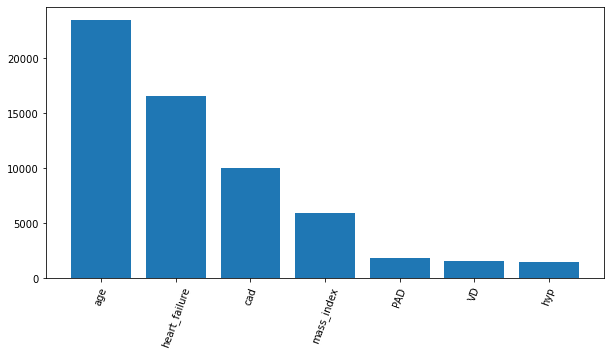

In [10]:
feature_imporance_havoc = automl.get_feature_scores(data=data_for_classificator, silent=False)
f, ax = plt.subplots(figsize=(10,5))
plt.bar([feature_imporance_havoc.Feature[x] for x in range(len(feature_imporance_havoc))], [feature_imporance_havoc.Importance[x] for x in range(len(feature_imporance_havoc))])
plt.xticks(rotation=70)
plt.show()